## ESPM 50AC

### Final Project: Using Data Science To Illustrate The Relationship Between Concentrated Marginalized Groups and the Spatial Distribution of GHG Emissions 


#### Sharan Sahu

## Introduction

 As we have discussed multiple times in lectures and discussions, global climate change seems to impact marginalized groups the most although they have contributed the least to climate change. A recent field of study that seeks to use datasets and data analysis to create insights about the impact of climate change on different social groups is called environmental data science. Furthermore, in documentaries such as Fence Line, we have seen how oil and power companies are located near marginalized communities, thus creating disparities in terms of climate change effects on these groups. This creative project seeks to use demographic datasets and datasets from the Environmental Protection Agency regarding greenhouse gas reporting to visualize the relationship between the spatial distribution of marginalized groups and GHG Emissions. This will use technologies such as Python and various data science packages to create visualizations. As an extension of this project if time permits, I will attempt to use machine learning techniques such as forecasting to illustrate a time series of how the spatial distribution of GHG emissions has been correlated with the spatial distribution of marginalized groups and how it may change in the future. This project also seeks to create insights that we have not discussed in class such as the relationship between the spatial distribution of GHG emissions and other minority groups that we have not investigated thoroughly.


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
# import contextily as ctx
import geoplot.crs as gcrs
import cartopy.crs as ccrs
import cartopy
import geoplot as gplt
import matplotlib as mpl
from matplotlib import pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from folium.plugins import MarkerCluster, HeatMap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")

## Exploratory Data Analysis And Cleaning For EPA GHG Reporting Dataset

We first load up the data to see what the data looks like. The columns of the dataset are wordy, so we can change th e names of the columns to be just the word following the period. We can also disregard any data that will not be used within the context of this project.

The dataset used is from [EPA Greenhouse Gas Reporting Program (GHGRP)](https://www.epa.gov/ghgreporting/ghg-reporting-program-data-sets). The GHGRP requires facilities emitting 25,000 metric tons ($mt$) of carbon dioxide equivalent ($CO_2e$) per year to report their emissions and many other related information annually.

In [2]:
emissions_data_summary = pd.read_csv("data_summary.CSV")

In [3]:
emissions_data_summary.head()

V_GHG_EMITTER_SUBPART.ADDRESS1  V_GHG_EMITTER_SUBPART.ADDRESS2  \
0         310 East Frontage Road                             NaN   
1              15400 VILLWOCK RD                             NaN   
2                            NaN                             NaN   
3   15 MILES N.W. OF WENDOVER NV                             NaN   
4                  11910 CR 492                              NaN   

  V_GHG_EMITTER_SUBPART.CITY  V_GHG_EMITTER_SUBPART.CO2E_EMISSION  \
0                   Kaukauna                             2349.400   
1                EDWARDSPORT                              746.192   
2                    Barstow                            21499.500   
3              WEST WENDOVER                           346763.600   
4                      TYLER                               56.250   

  V_GHG_EMITTER_SUBPART.COUNTY  V_GHG_EMITTER_SUBPART.FACILITY_ID  \
0                    Outagamie                            1000421   
1                         Knox                            1001541   
2                  WARD COUNTY                            1005215   
3                  ELKO COUNTY                            1005828   
4                 SMITH COUNTY                            1001662   

  V_GHG_EMITTER_SUBPART.GAS_CODE V_GHG_EMITTER_SUBPART.GAS_NAME  \
0                            CO2                 Carbon Dioxide   
1                            N2O                  Nitrous Oxide   
2                            CH4                        Methane   
3                            CO2                 Carbon Dioxide   
4                            CH4                        Methane   

   V_GHG_EMITTER_SUBPART.LATITUDE  V_GHG_EMITTER_SUBPART.LONGITUDE  \
0                        44.32040                       -88.208900   
1                        38.80670                       -87.247200   
2                        31.52250                      -103.465278   
3                        40.82126                      -114.250199   
4                        32.43442                       -95.362850   

  V_GHG_EMITTER_SUBPART.STATE V_GHG_EMITTER_SUBPART.STATE_NAME  \
0                          WI                        WISCONSIN   
1                          IN                          INDIANA   
2                          TX                            TEXAS   
3                          NV                           NEVADA   
4                          TX                            TEXAS   

  V_GHG_EMITTER_SUBPART.SUBPART_CATEGORY V_GHG_EMITTER_SUBPART.SUBPART_NAME  \
0                  Stationary Combustion                                  C   
1                 Electricity Generation                                  D   
2      Petroleum and Natural Gas Systems                                  W   
3                        Lime Production                                  S   
4                  Stationary Combustion                                  C   

  V_GHG_EMITTER_SUBPART.SUBPART_TYPE  V_GHG_EMITTER_SUBPART.YEAR  \
0                                  E                        2018   
1                                  E                        2016   
2                                  E                        2016   
3                                  E                        2016   
4                                  E                        2017   

   V_GHG_EMITTER_SUBPART.ZIP V_GHG_EMITTER_SUBPART.FACILITY_NAME  \
0                      54130                   Fox Energy Center   
1                      47500                         Edwardsport   
2                      79719                Mivida Treater Plant   
3                      89883  GRAYMONT WESTERN US INC PILOT PEAK   
4                      75706                  TYLER PIPE COMPANY   

   V_GHG_EMITTER_SUBPART.GHG_QUANTITY  V_GHG_EMITTER_SUBPART.COUNTY_FIPS  
0                            2349.400                            55087.0  
1                               2.504                            18083.0  
2                       

In [4]:
new_column_names = []
for columns in emissions_data_summary.columns:
    new_column_names.append(columns.split('.')[1])
emissions_data_summary.columns = new_column_names

In [5]:
data_formatted = emissions_data_summary[['ADDRESS1', 'ADDRESS2', 'CITY', 'CO2E_EMISSION', 'COUNTY',
       'FACILITY_ID', 'GAS_CODE', 'GAS_NAME', 'LATITUDE', 'LONGITUDE', 'STATE',
       'STATE_NAME', 'YEAR', 'ZIP', 'FACILITY_NAME', 'GHG_QUANTITY']]
data_formatted

ADDRESS1  ADDRESS2           CITY  CO2E_EMISSION  \
0             310 East Frontage Road       NaN       Kaukauna       2349.400   
1                  15400 VILLWOCK RD       NaN    EDWARDSPORT        746.192   
2                                NaN       NaN        Barstow      21499.500   
3       15 MILES N.W. OF WENDOVER NV       NaN  WEST WENDOVER     346763.600   
4                      11910 CR 492        NaN          TYLER         56.250   
...                              ...       ...            ...            ...   
278210                  71 MONAS WAY       NaN          SALEM      32903.900   
278211         17700 South Highway T       NaN      Deerfield         14.500   
278212          1 ThyssenKrupp Drive       NaN        Calvert         18.476   
278213            105 East Port Lane       NaN    Summerville         17.880   
278214                3848 470th Ave       NaN     Emmetsburg         68.838   

                   COUNTY  FACILITY_ID GAS_CODE        GAS_NAME   LATITUDE  \
0               Outagamie      1000421      CO2  Carbon Dioxide  44.320400   
1                    Knox      1001541      N2O   Nitrous Oxide  38.806700   
2             WARD COUNTY      1005215      CH4         Methane  31.522500   
3             ELKO COUNTY      1005828      CO2  Carbon Dioxide  40.821260   
4            SMITH COUNTY      1001662      CH4         Methane  32.434420   
...                   ...          ...      ...             ...        ...   
278210   DODDRIDGE COUNTY      1011071      CO2  Carbon Dioxide  39.207500   
278211      VERNON COUNTY      1010610      CH4         Methane  37.807250   
278212         WASHINGTON      1010763      N2O   Nitrous Oxide  31.156240   
278213  DORCHESTER COUNTY      1011691      N2O   Nitrous Oxide  33.044777   
278214   PALO ALTO COUNTY      1011694      N2O   Nitrous Oxide  43.089625   

         LONGITUDE STATE      STATE_NAME  YEAR    ZIP  \
0       -88.208900    WI       WISCONSIN  2018  54130   
1       -87.247200    IN         INDIANA  2016  47500   
2      -103.465278    TX           TEXAS  2016  79719   
3      -114.250199    NV          NEVADA  2016  89883   
4       -95.362850    TX           TEXAS  2017  75706   
...            ...   ...             ...   ...    ...   
278210  -80.554080    WV   WEST VIRGINIA  2014  26426   
278211  -94.585301    MO        MISSOURI  2014  64741   
278212  -88.012750    AL         ALABAMA  2012  36513   
278213  -80.210887    SC  SOUTH CAROLINA  2018  29483   
278214  -94.646632    IA            IOWA  2014  50536   

                             FACILITY_NAME  GHG_QUANTITY  
0                        Fox Energy Center      2349.400  
1                              Edwardsport         2.504  
2                     Mivida Treater Plant       859.980  
3       GRAYMONT WESTERN US INC PILOT PEAK    346763.600  
4                       TYLER PIPE COMPANY         2.250  
...                                    ...           ...  
278210           MORGAN COMPRESSOR STATION     32903.900  
278211                       ADM Deerfield         0.580  
278212        Outokumpu Stainless USA  LLC         0.062  
278213         Lauscha Fiber International         0.060  
278214        POET DSM Project Liberty LLC         0.231  

[278215 rows x 16 columns]

## Data Insights and Analysis For EPA GHG Reporting Dataset

Below, we are given some insights into the GHG emissions broken down by state between the period of 2010-2019. Surprisingly, in terms of total GHG emissions during this period, Texas has been the greatest contributor of GHG emissions by a large margin compared to other states. In 2019, Texas became the nation's number 1 carbon dioxide  emitter and according to an article posted by the Federal Reserve Bank of Dallas by authors Emma Marshall and Jesse Thompson, "Texas’ high industrial share largely results from the production of energy-intensive goods such as motor fuels and petrochemicals, which yields substantial CO2 waste. The state is home to 30 percent of U.S. refining capacity and 70 percent of the nation’s basic petrochemical capacity." (Marshall and Thompson 10) [(Link to Article)](https://www.dallasfed.org/~/media/documents/research/swe/2019/swe1903c.pdf)

[]

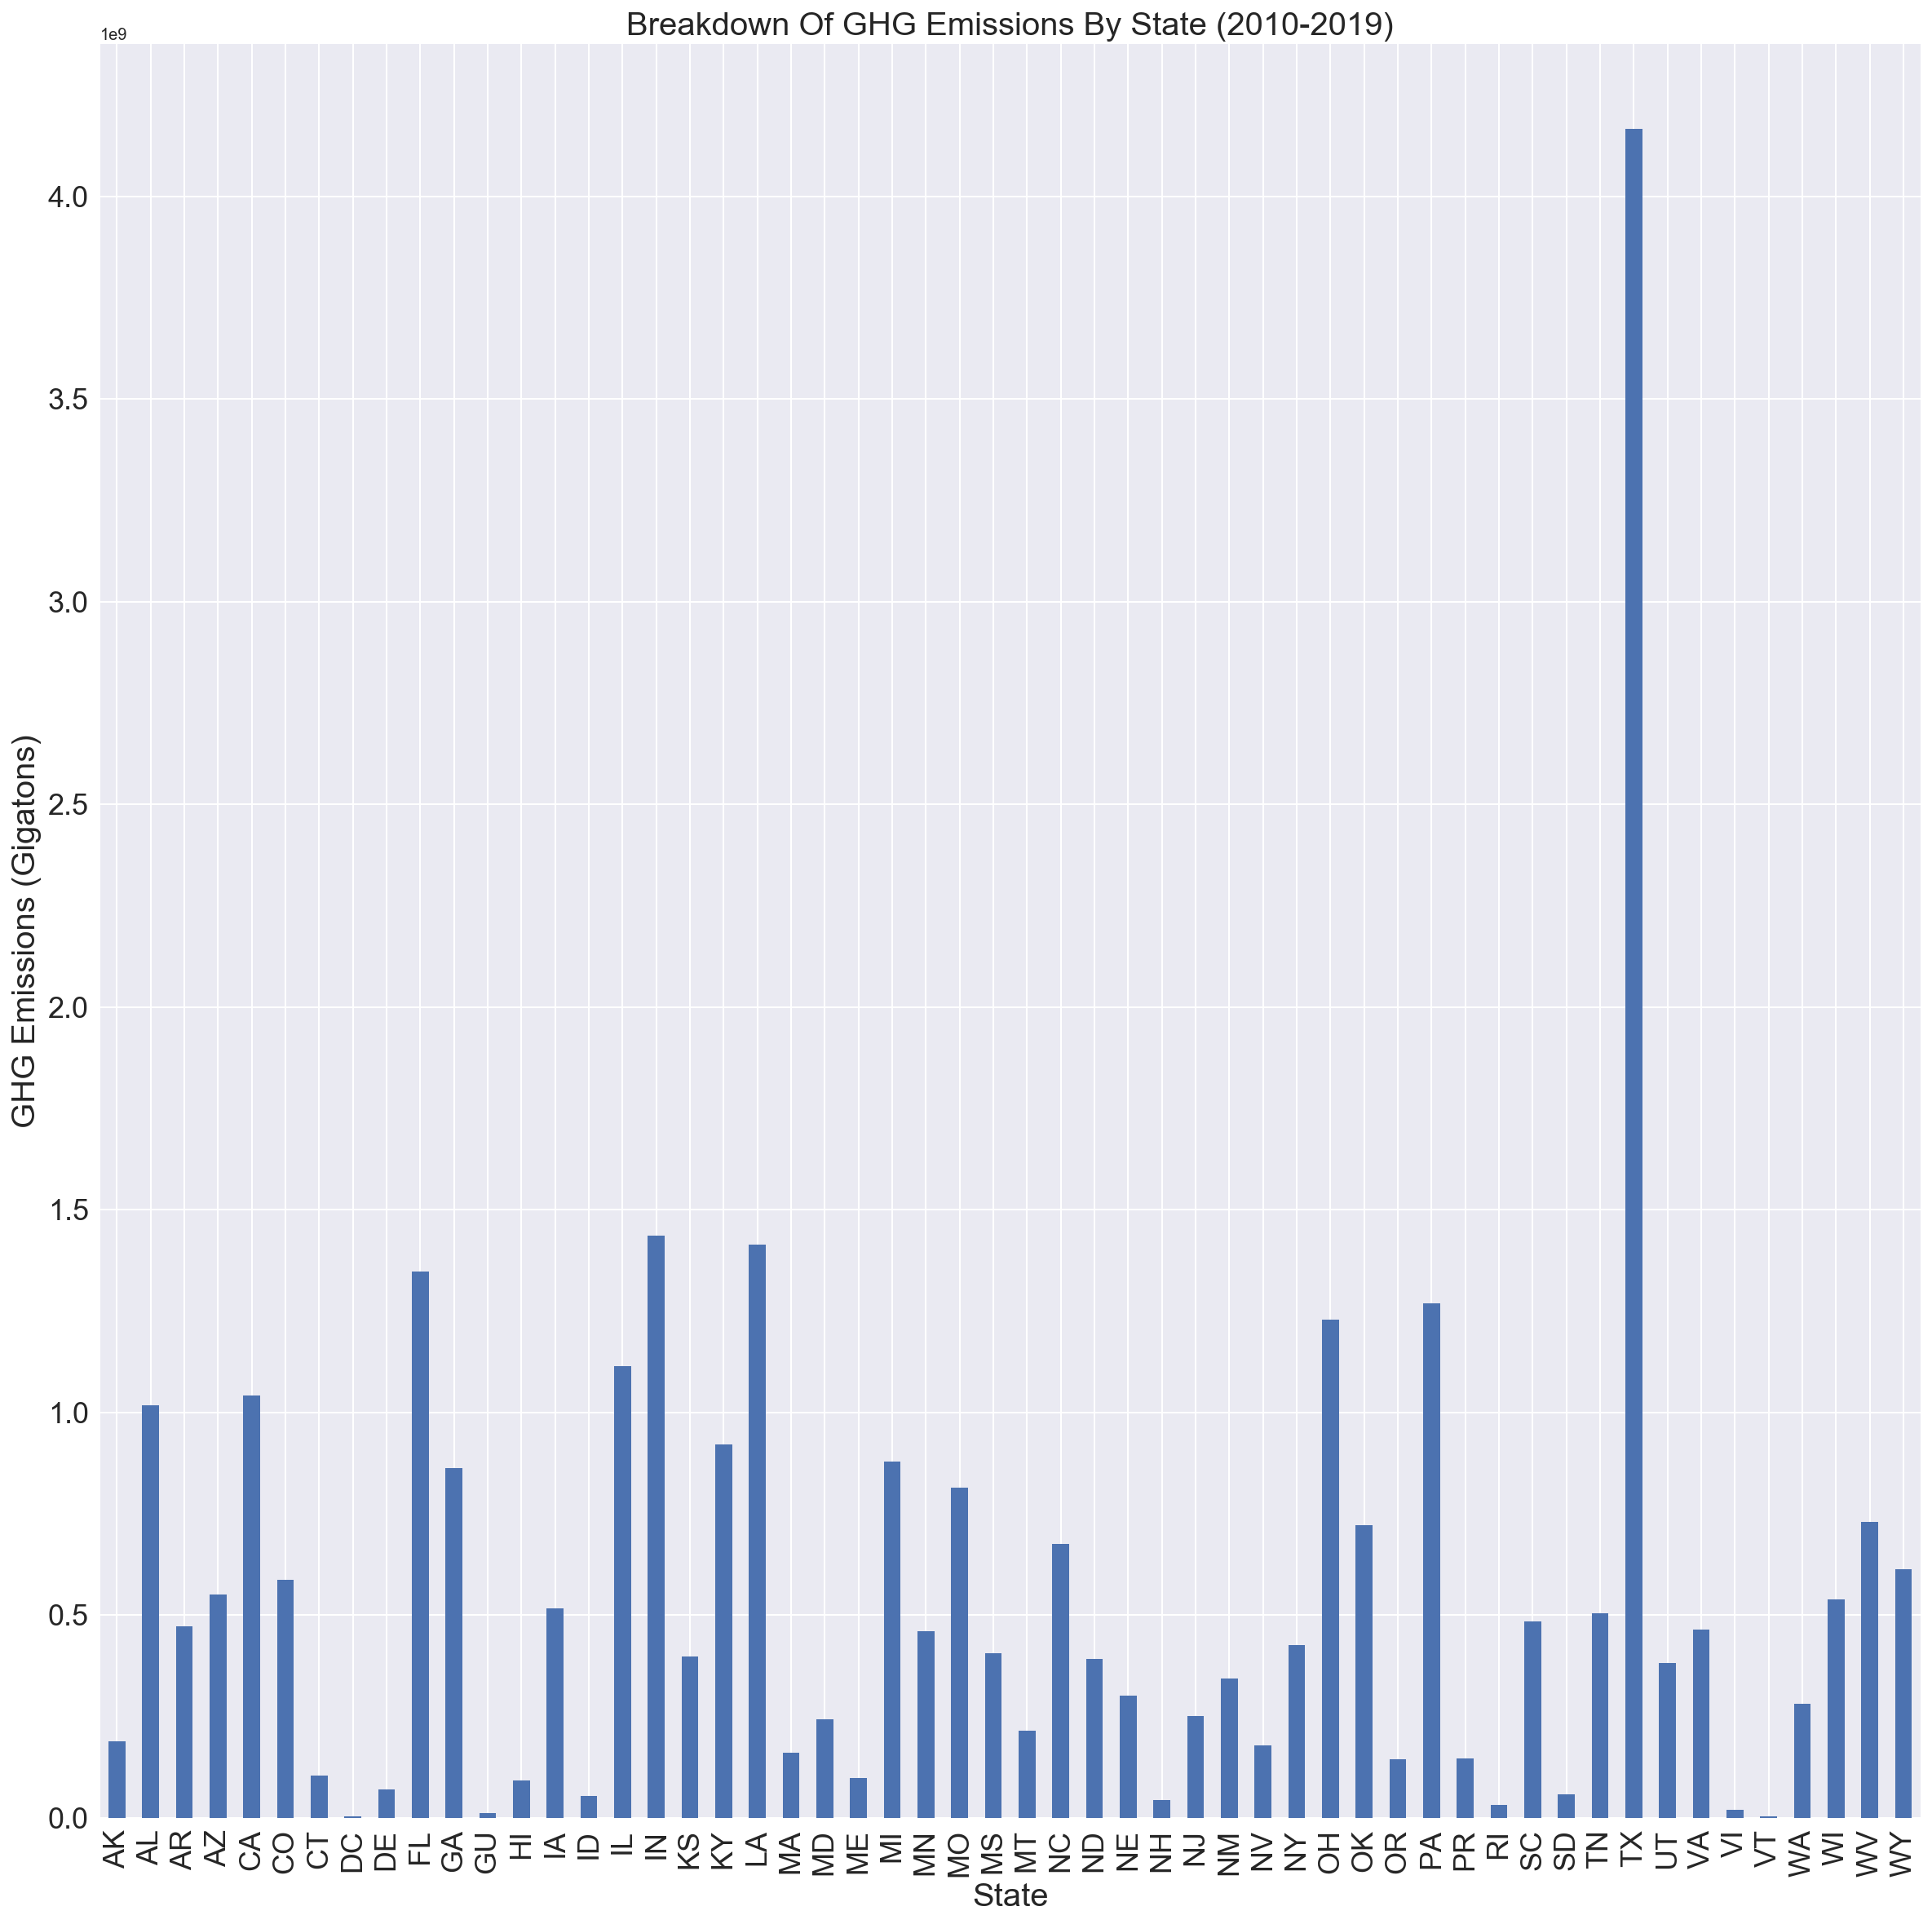

In [6]:
state_data = data_formatted.groupby("STATE").aggregate(np.sum)
state_data_plot = state_data.plot(y="GHG_QUANTITY", kind ='bar', figsize = (20, 20), legend = False, fontsize = 18)
state_data_plot.set_title(r"Breakdown Of GHG Emissions By State (2010-2019)", fontsize = 20)
state_data_plot.set_xlabel("State", fontsize = 20)
state_data_plot.set_ylabel("GHG Emissions (Gigatons)", fontsize = 20)
plt.plot()

Based on the information we have above, it is not surprising to see that Texas was the number one GHG emitter in 2019.

[]

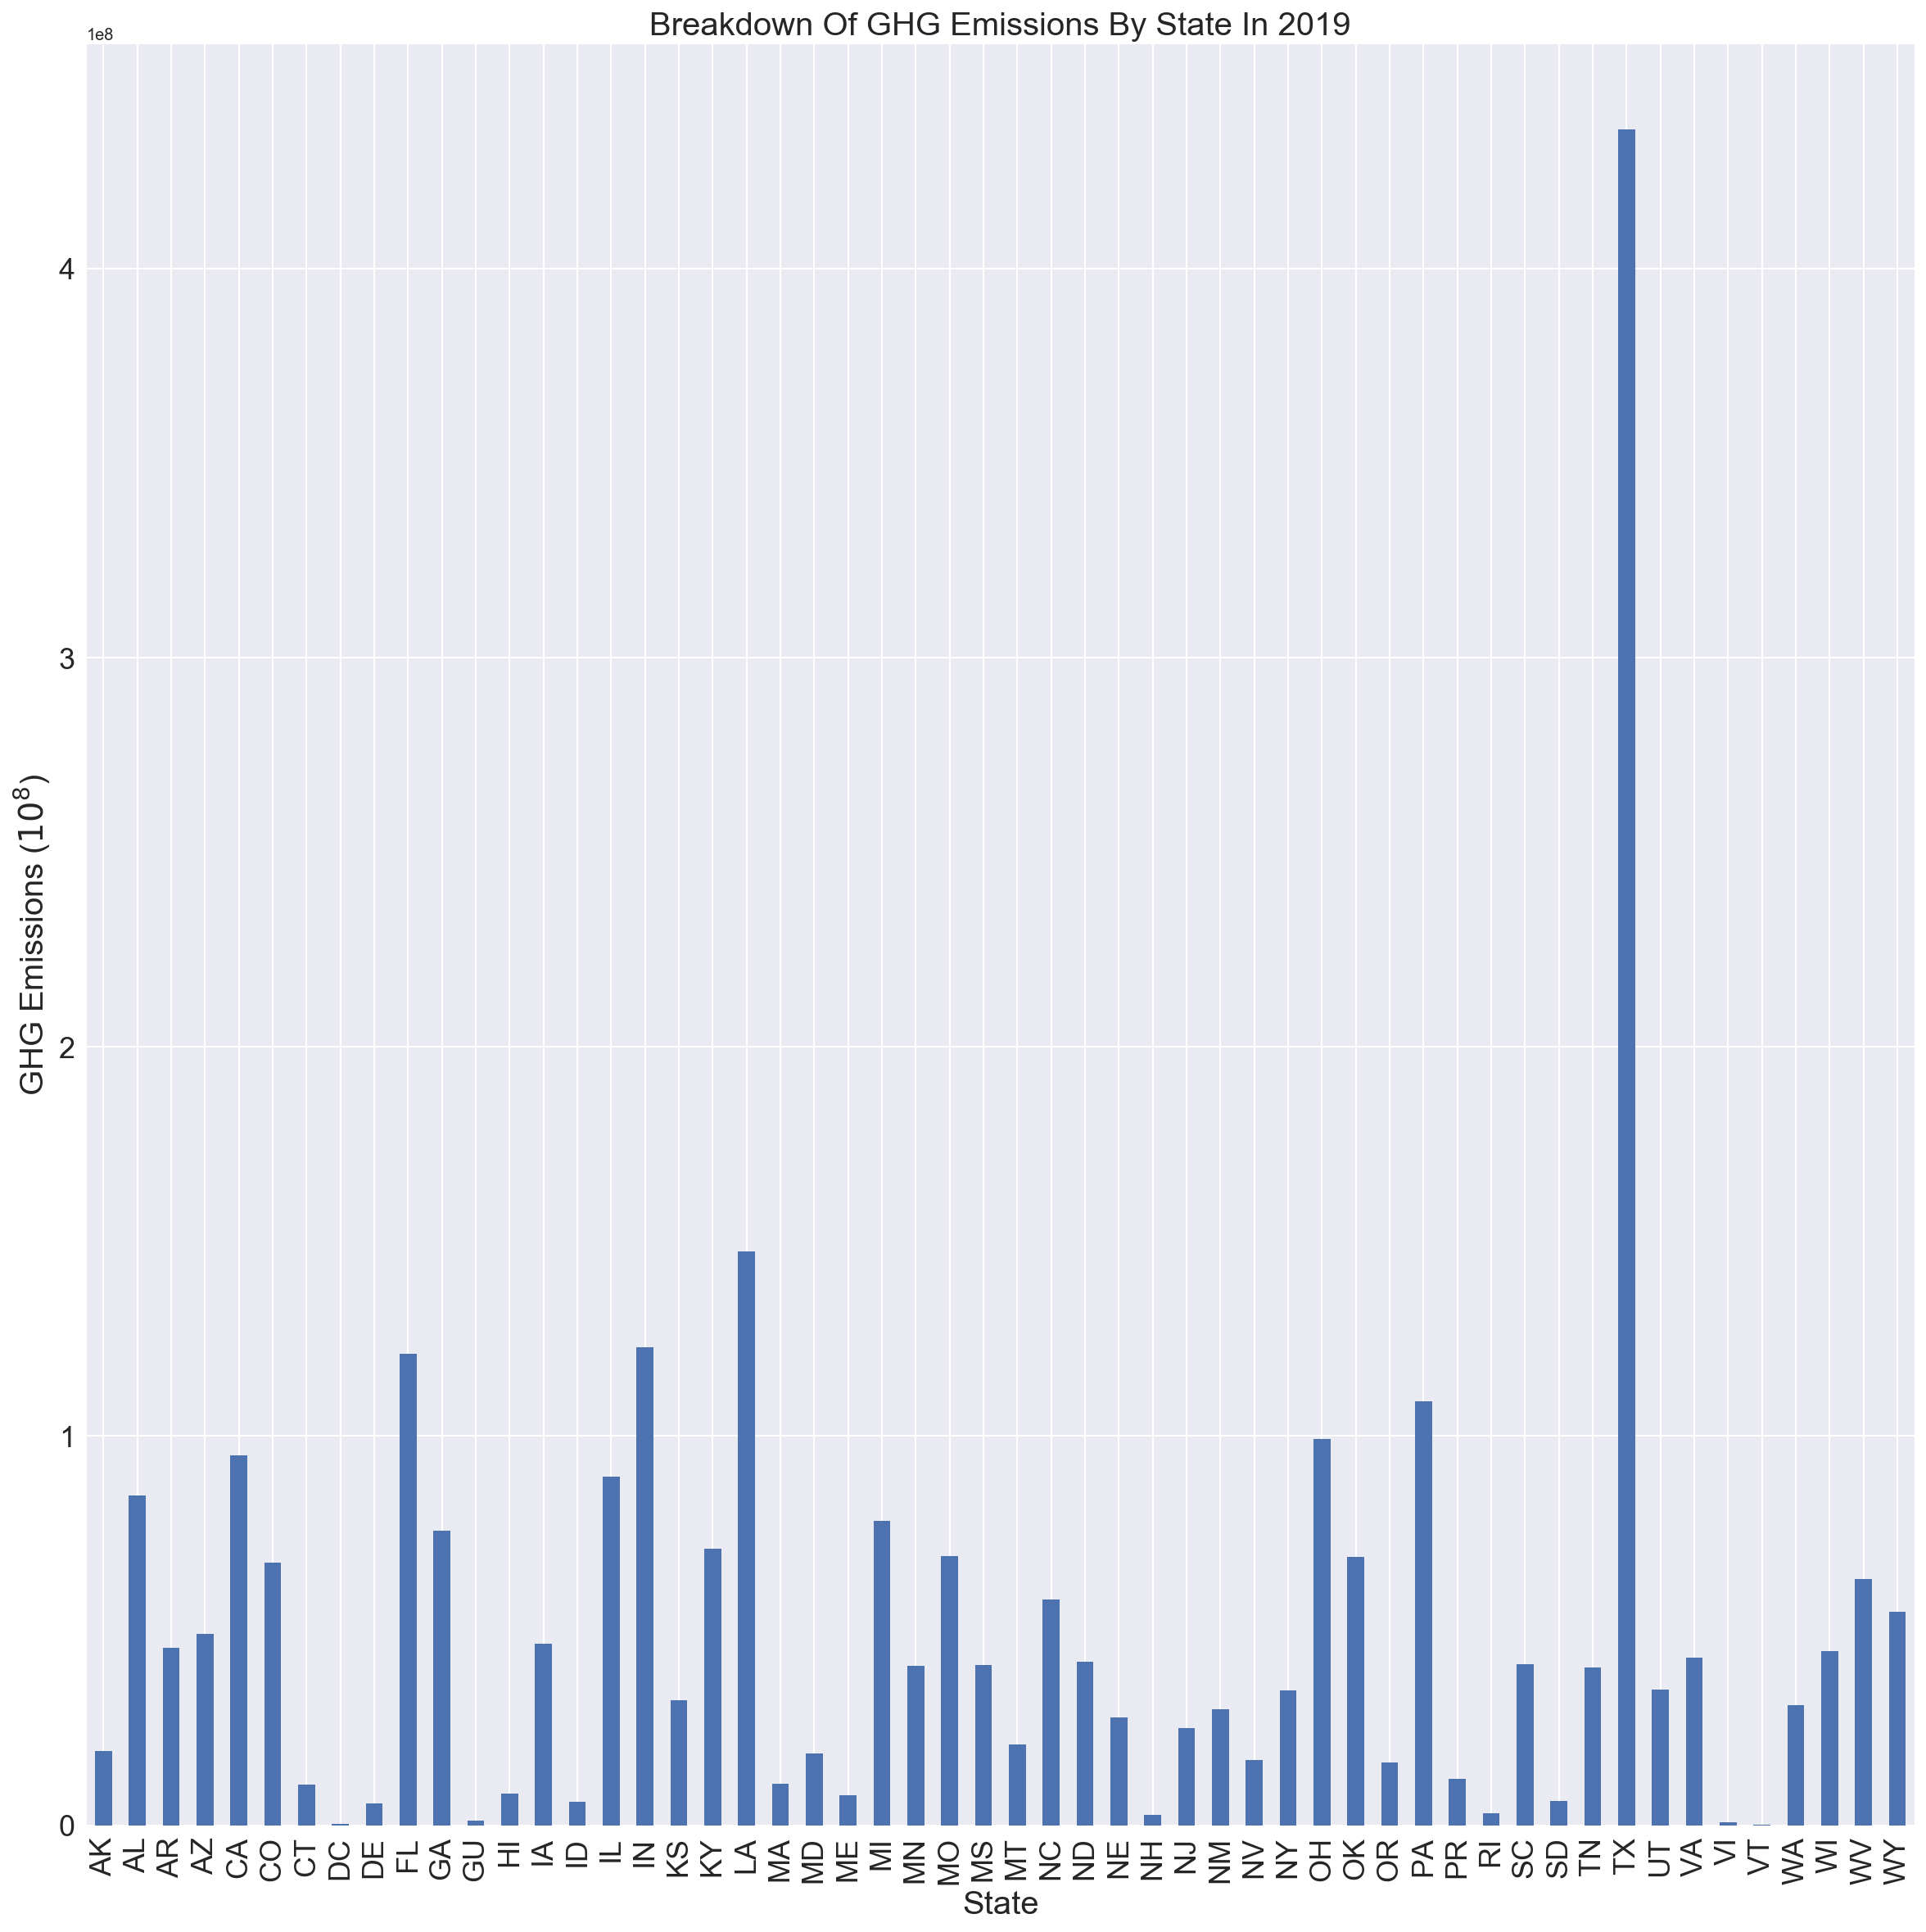

In [7]:
data_2019 = data_formatted[data_formatted['YEAR'] == 2019]

state_data_2019 = data_2019.groupby("STATE").aggregate(np.sum)

state_data_2019_plot = state_data_2019.plot(y="GHG_QUANTITY", kind ='bar', figsize = (20, 20), legend = False, fontsize = 18)
state_data_2019_plot.set_title('Breakdown Of GHG Emissions By State In 2019', fontsize = 20)
state_data_2019_plot.set_xlabel("State", fontsize = 20)
state_data_2019_plot.set_ylabel(r"GHG Emissions ($10^8$)", fontsize = 20)
plt.plot()

Below is a breakdown of the GHG emission usage from the period of 2010-2019. As we have seen before, Carbon Dioxide is the largest GHG Emission contributor, and this makes sense to why Texas has jumped up so highly when discussing GHG emissions since in 2019, they became the nation's number 1 carbon dioxide emitter.

[]

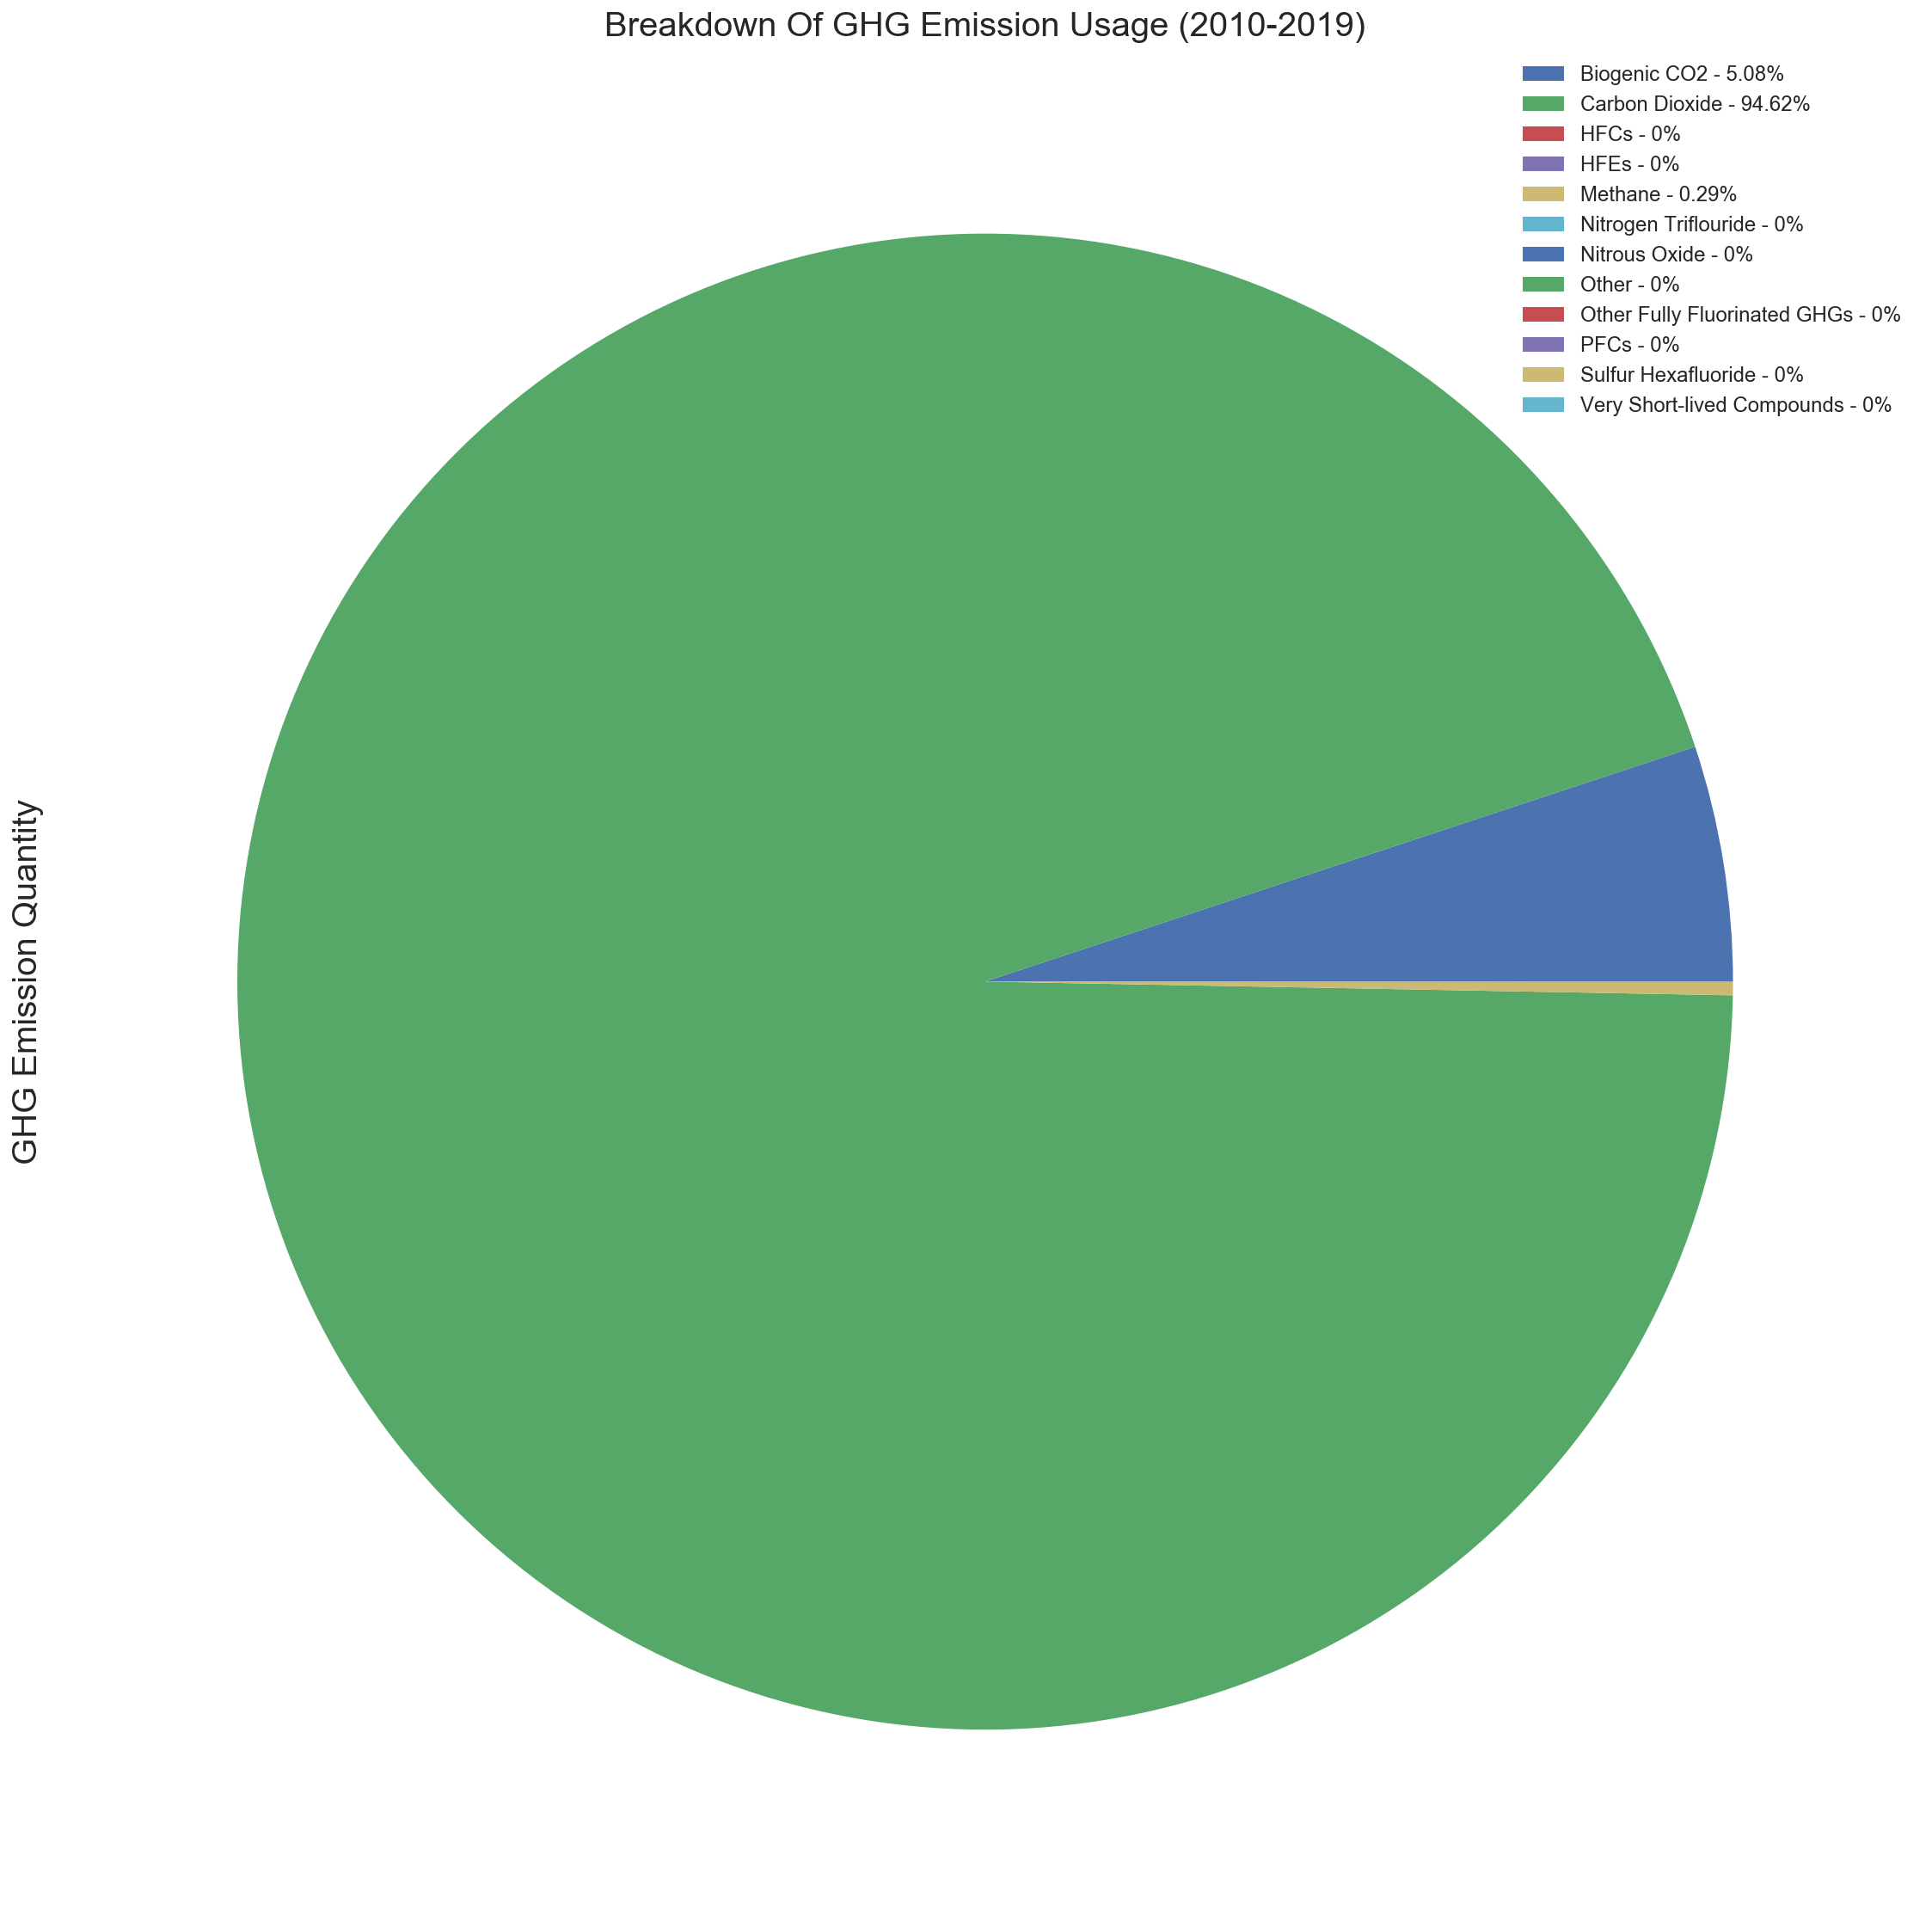

In [8]:
ghg_emission_breakdown = data_formatted.groupby("GAS_NAME").aggregate(np.sum)
ghg_emission_breakdown_plot = ghg_emission_breakdown.plot.pie(y="GHG_QUANTITY", figsize = (20, 20), legend = True, labels = ['' for i in range(len(data_formatted["GAS_NAME"]))])
ghg_emission_breakdown_plot.set_title("Breakdown Of GHG Emission Usage (2010-2019)", fontsize = 20)
ghg_emission_breakdown_plot.set_ylabel("GHG Emission Quantity", fontsize = 20)
total_emissions = sum(ghg_emission_breakdown['GHG_QUANTITY'])
percentages = [round(100.*i/total_emissions, 2)  for i in ghg_emission_breakdown['GHG_QUANTITY']]
ghg_emission_breakdown['GHG Percentage'] = percentages
labels = [
    "Biogenic CO2 - 5.08%",
    "Carbon Dioxide - 94.62%",
    "HFCs - 0%",
    "HFEs - 0%",
    "Methane - 0.29%",
    "Nitrogen Triflouride - 0%",
    "Nitrous Oxide - 0%",
    "Other - 0%",
    "Other Fully Fluorinated GHGs - 0%",
    "PFCs - 0%",
    "Sulfur Hexafluoride - 0%",
    "Very Short-lived Compounds - 0%",
]
plt.legend(labels, fontsize = 12)
plt.plot()

Although the United States has been one of the leading nations when discussing GHG emissions, it looks like while we are still emitting close to 3 gigatons of GHG, we are slowly making progress to reducing our GHG emissions through policy, adaptation, and mitigation

Text(0.5, 1.0, 'Progression of GHG Emissions (2010-2019)')

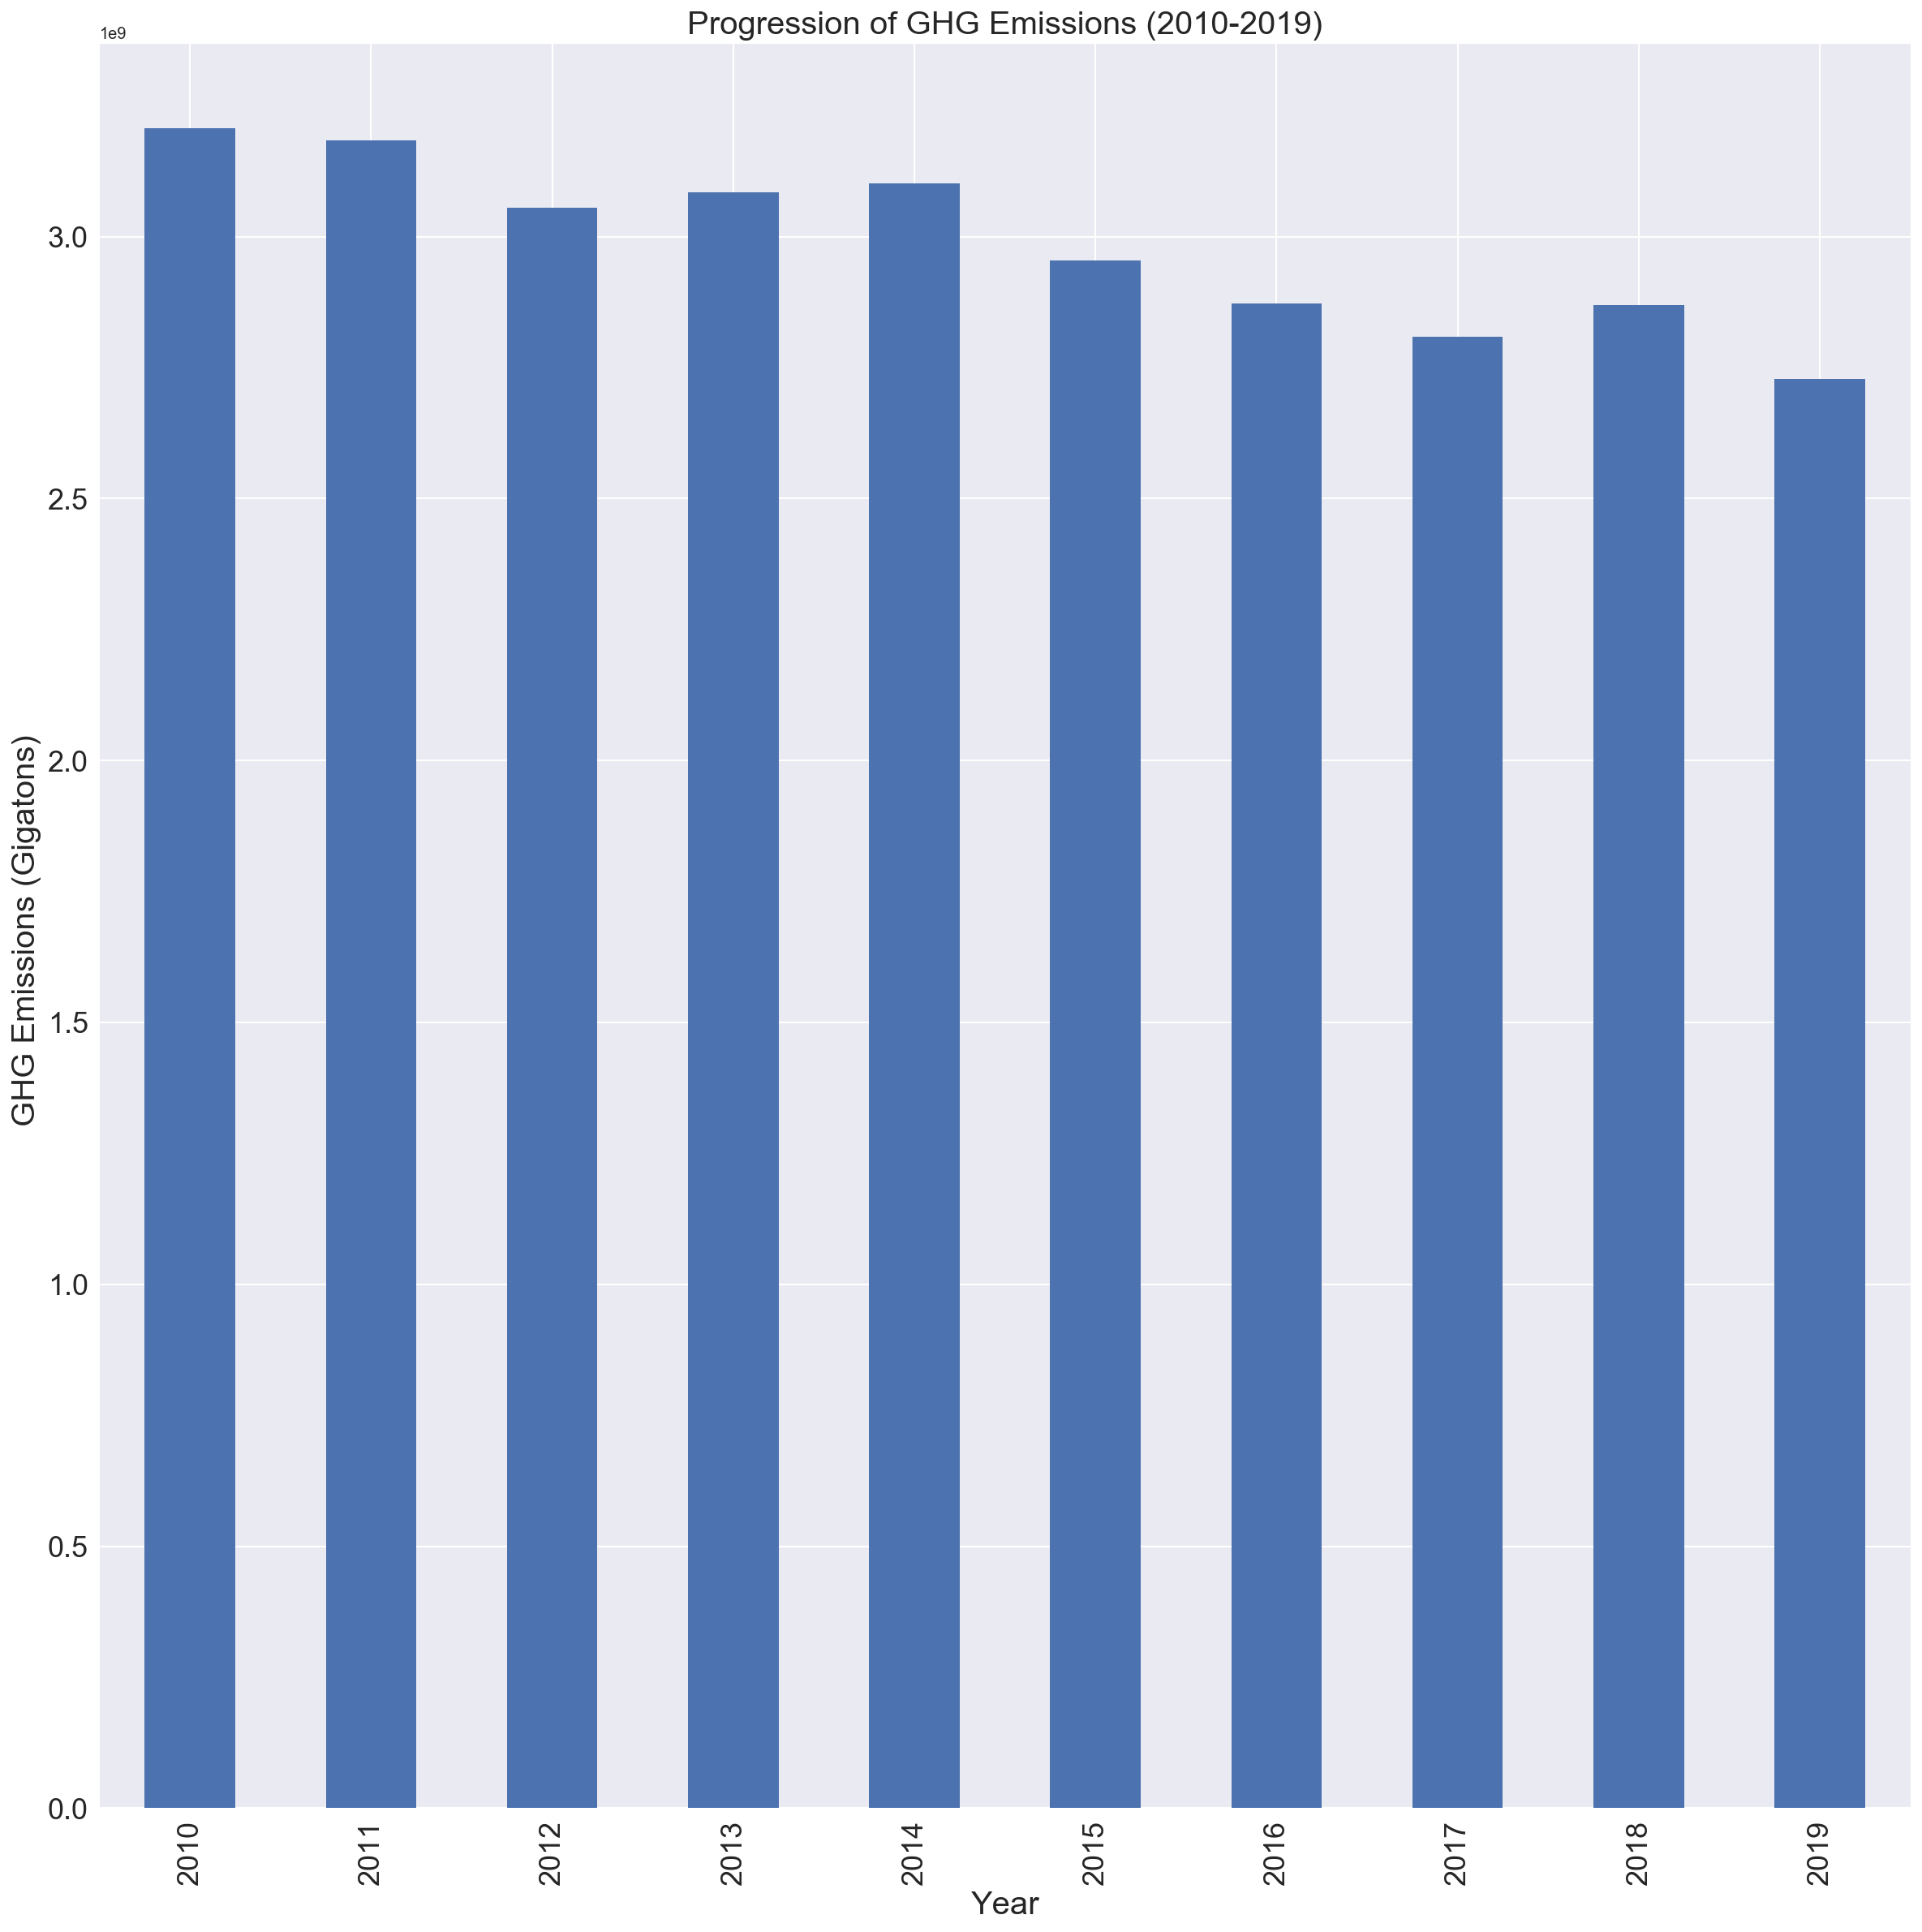

In [9]:
year_breakdown = data_formatted.groupby("YEAR").aggregate(np.sum)
year_breakdown_plot = year_breakdown.plot.bar(y = "GHG_QUANTITY", legend = False, figsize = (20, 20), fontsize = 18)
year_breakdown_plot.set_xlabel("Year", fontsize = 20)
year_breakdown_plot.set_ylabel("GHG Emissions (Gigatons) ", fontsize = 20)
year_breakdown_plot.set_title("Progression of GHG Emissions (2010-2019)", fontsize = 20)

## Exploratory Data Analysis And Cleaning For 2017 United States Census Dataset


We will now take a look at the demographics of the United States, particularly with the 2017 Census Data. With this data, we can take into account the demographics of different states within the United States and deduce which states emit the most GHG and have the greatest underrepresented minority groups. Below, we are doing some exploring of the data to see which information is most relevant, and filtering out the information that is not necessary for the analysis.

The data set used below is from [United States Census Bureau](https://data.census.gov/cedsci/profile?g=0100000US)

In [10]:
census_data_2017 = pd.read_csv("acs2017_county_data.csv")
census_data_2017.columns

Index(['CountyId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

In [11]:
census_data_formatted = census_data_2017[['CountyId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific']]
census_data_formatted

CountyId        State               County  TotalPop    Men   Women  \
0         1001      Alabama       Autauga County     55036  26899   28137   
1         1003      Alabama       Baldwin County    203360  99527  103833   
2         1005      Alabama       Barbour County     26201  13976   12225   
3         1007      Alabama          Bibb County     22580  12251   10329   
4         1009      Alabama        Blount County     57667  28490   29177   
...        ...          ...                  ...       ...    ...     ...   
3215     72145  Puerto Rico  Vega Baja Municipio     54754  26269   28485   
3216     72147  Puerto Rico    Vieques Municipio      8931   4351    4580   
3217     72149  Puerto Rico   Villalba Municipio     23659  11510   12149   
3218     72151  Puerto Rico    Yabucoa Municipio     35025  16984   18041   
3219     72153  Puerto Rico      Yauco Municipio     37585  18052   19533   

      Hispanic  White  Black  Native  Asian  Pacific  
0          2.7   75.4   18.9     0.3    0.9      0.0  
1          4.4   83.1    9.5     0.8    0.7      0.0  
2          4.2   45.7   47.8     0.2    0.6      0.0  
3          2.4   74.6   22.0     0.4    0.0      0.0  
4          9.0   87.4    1.5     0.3    0.1      0.0  
...        ...    ...    ...     ...    ...      ...  
3215      96.7    3.1    0.1     0.0    0.0      0.0  
3216      95.7    4.0    0.0     0.0    0.0      0.0  
3217      99.7    0.2    0.1     0.0    0.0      0.0  
3218      99.9    0.1    0.0     0.0    0.0      0.0  
3219      99.8    0.2    0.0     0.0    0.0      0.0  

[3220 rows x 12 columns]

## Data Insights and Analysis For 2017 United States Census Dataset

Below, we can see a breakdown of minority racial groups within the United States as reported by the 2017 United States Census Dataset. As we see, the majority of minority groups are found within the state of Texas, Georgia, Mississipi, Louisiana, Virginia, and Puerto Rico. In the subsequent following this, we can begin to make some insights into the spatial distribution of minority groups and the spatial distribution of GHG emissions within the United States.

Text(0, 0.5, 'Population')

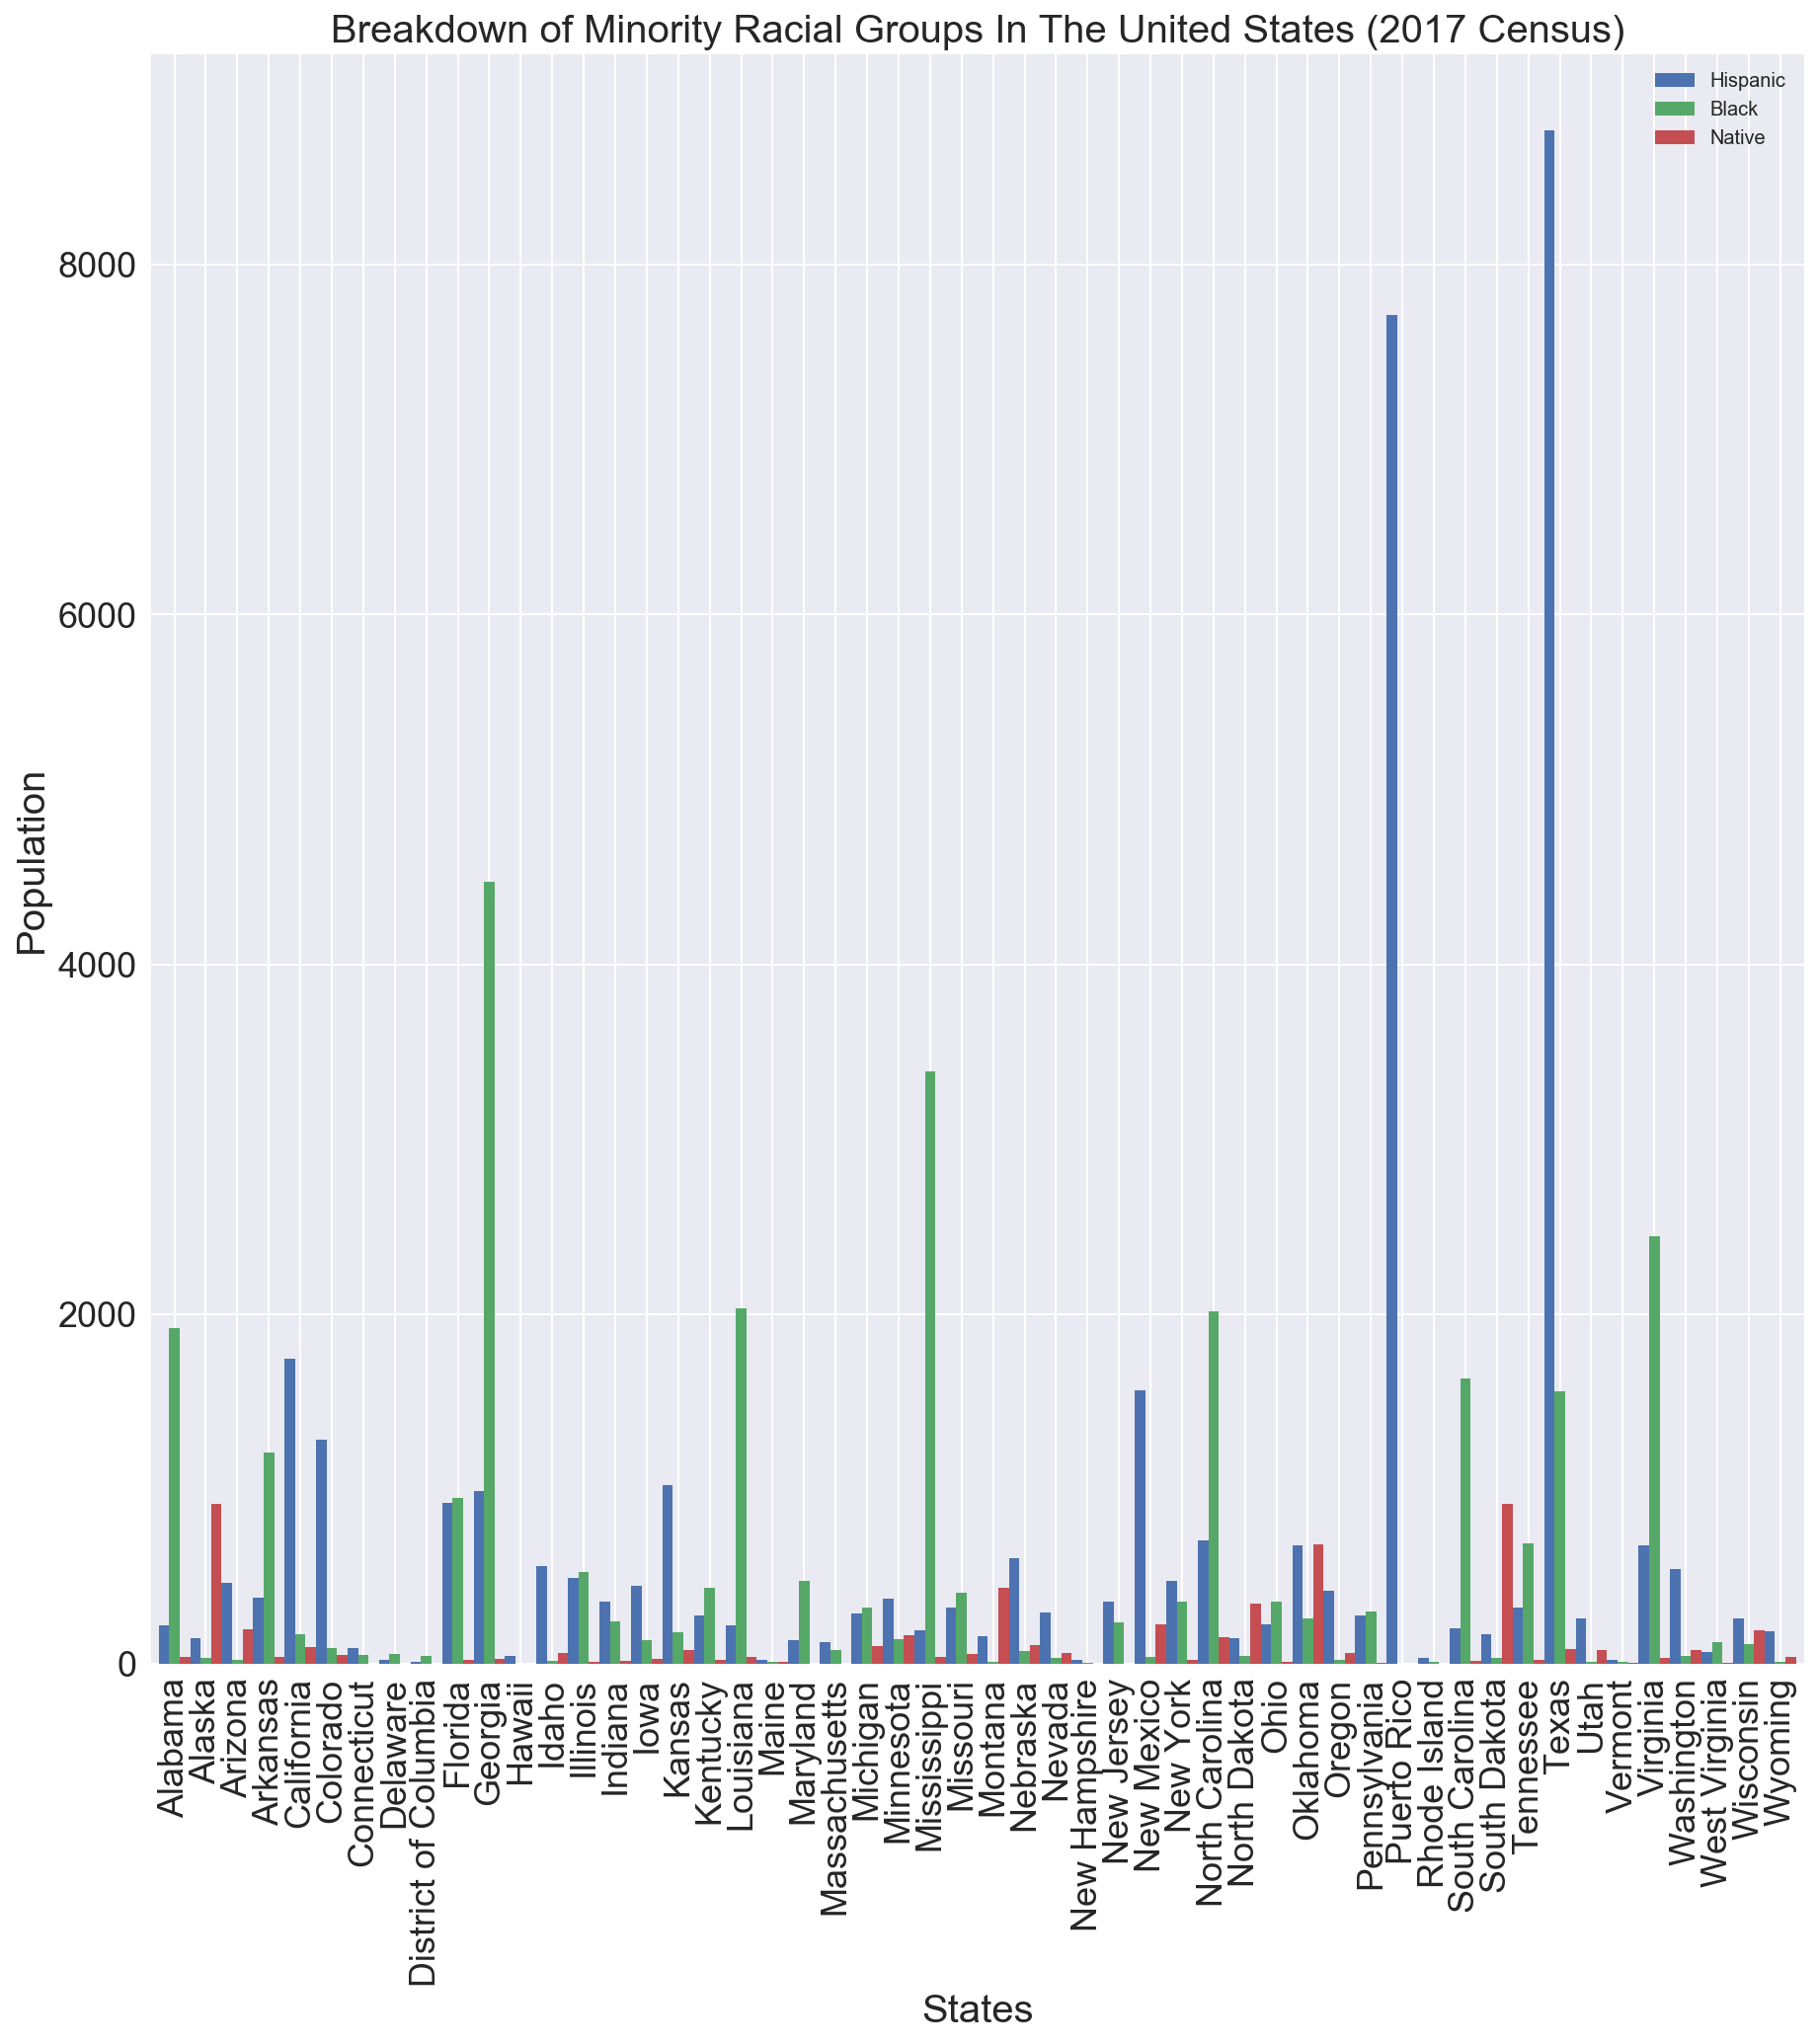

In [12]:
census_data_race_breakdown = census_data_formatted.groupby("State").aggregate(np.sum)
census_data_race_breakdown_plot = census_data_race_breakdown.plot.bar(y = ['Hispanic', 'Black', 'Native'], figsize = (15, 15), legend = True, fontsize = 18, width = 1)
census_data_race_breakdown_plot.set_title("Breakdown of Minority Racial Groups In The United States (2017 Census)", fontsize = 20)
census_data_race_breakdown_plot.set_xlabel("States", fontsize = 20)
census_data_race_breakdown_plot.set_ylabel("Population", fontsize = 20)

As we can see below, within the year of 2017, the states of Texas, Louisiana, and Georgia were amongst the state leaders in terms of climate change. In relation to the spatial distribution of minority groups, we already know the insights of environmental racism within Louisiana and New Orleans as discussed within the first 2 units of the course; however, we also begin to see a pattern of large Hispanic population and large GHG emissions within those particular states, particularly when discussing Puerto Rico and Texas. In fact, according to the Environmental Defense Fund (EDF), "Climate change has a tremendous impact on the health, livelihoods, and overall well-being of U.S. Latinos ... Latinos are more vulnerable to the effects of climate change because of where we live and work. More than half (55%) of Latino-Americans live in three states that are already experiencing serious effects related to climate change: historic drought in California, record-breaking heat in Texas, and increased sea level rise and flooding in Florida. Furthermore, Latinos are more likely to work in the industries that are deeply affected by the effects of climate change such as agriculture, manufacturing, and construction." (EDF) [(Link To Article)](https://www.edf.org/sites/default/files/content/latinos_and_climate_change_factsheet_0317_refresh.pdf)

[]

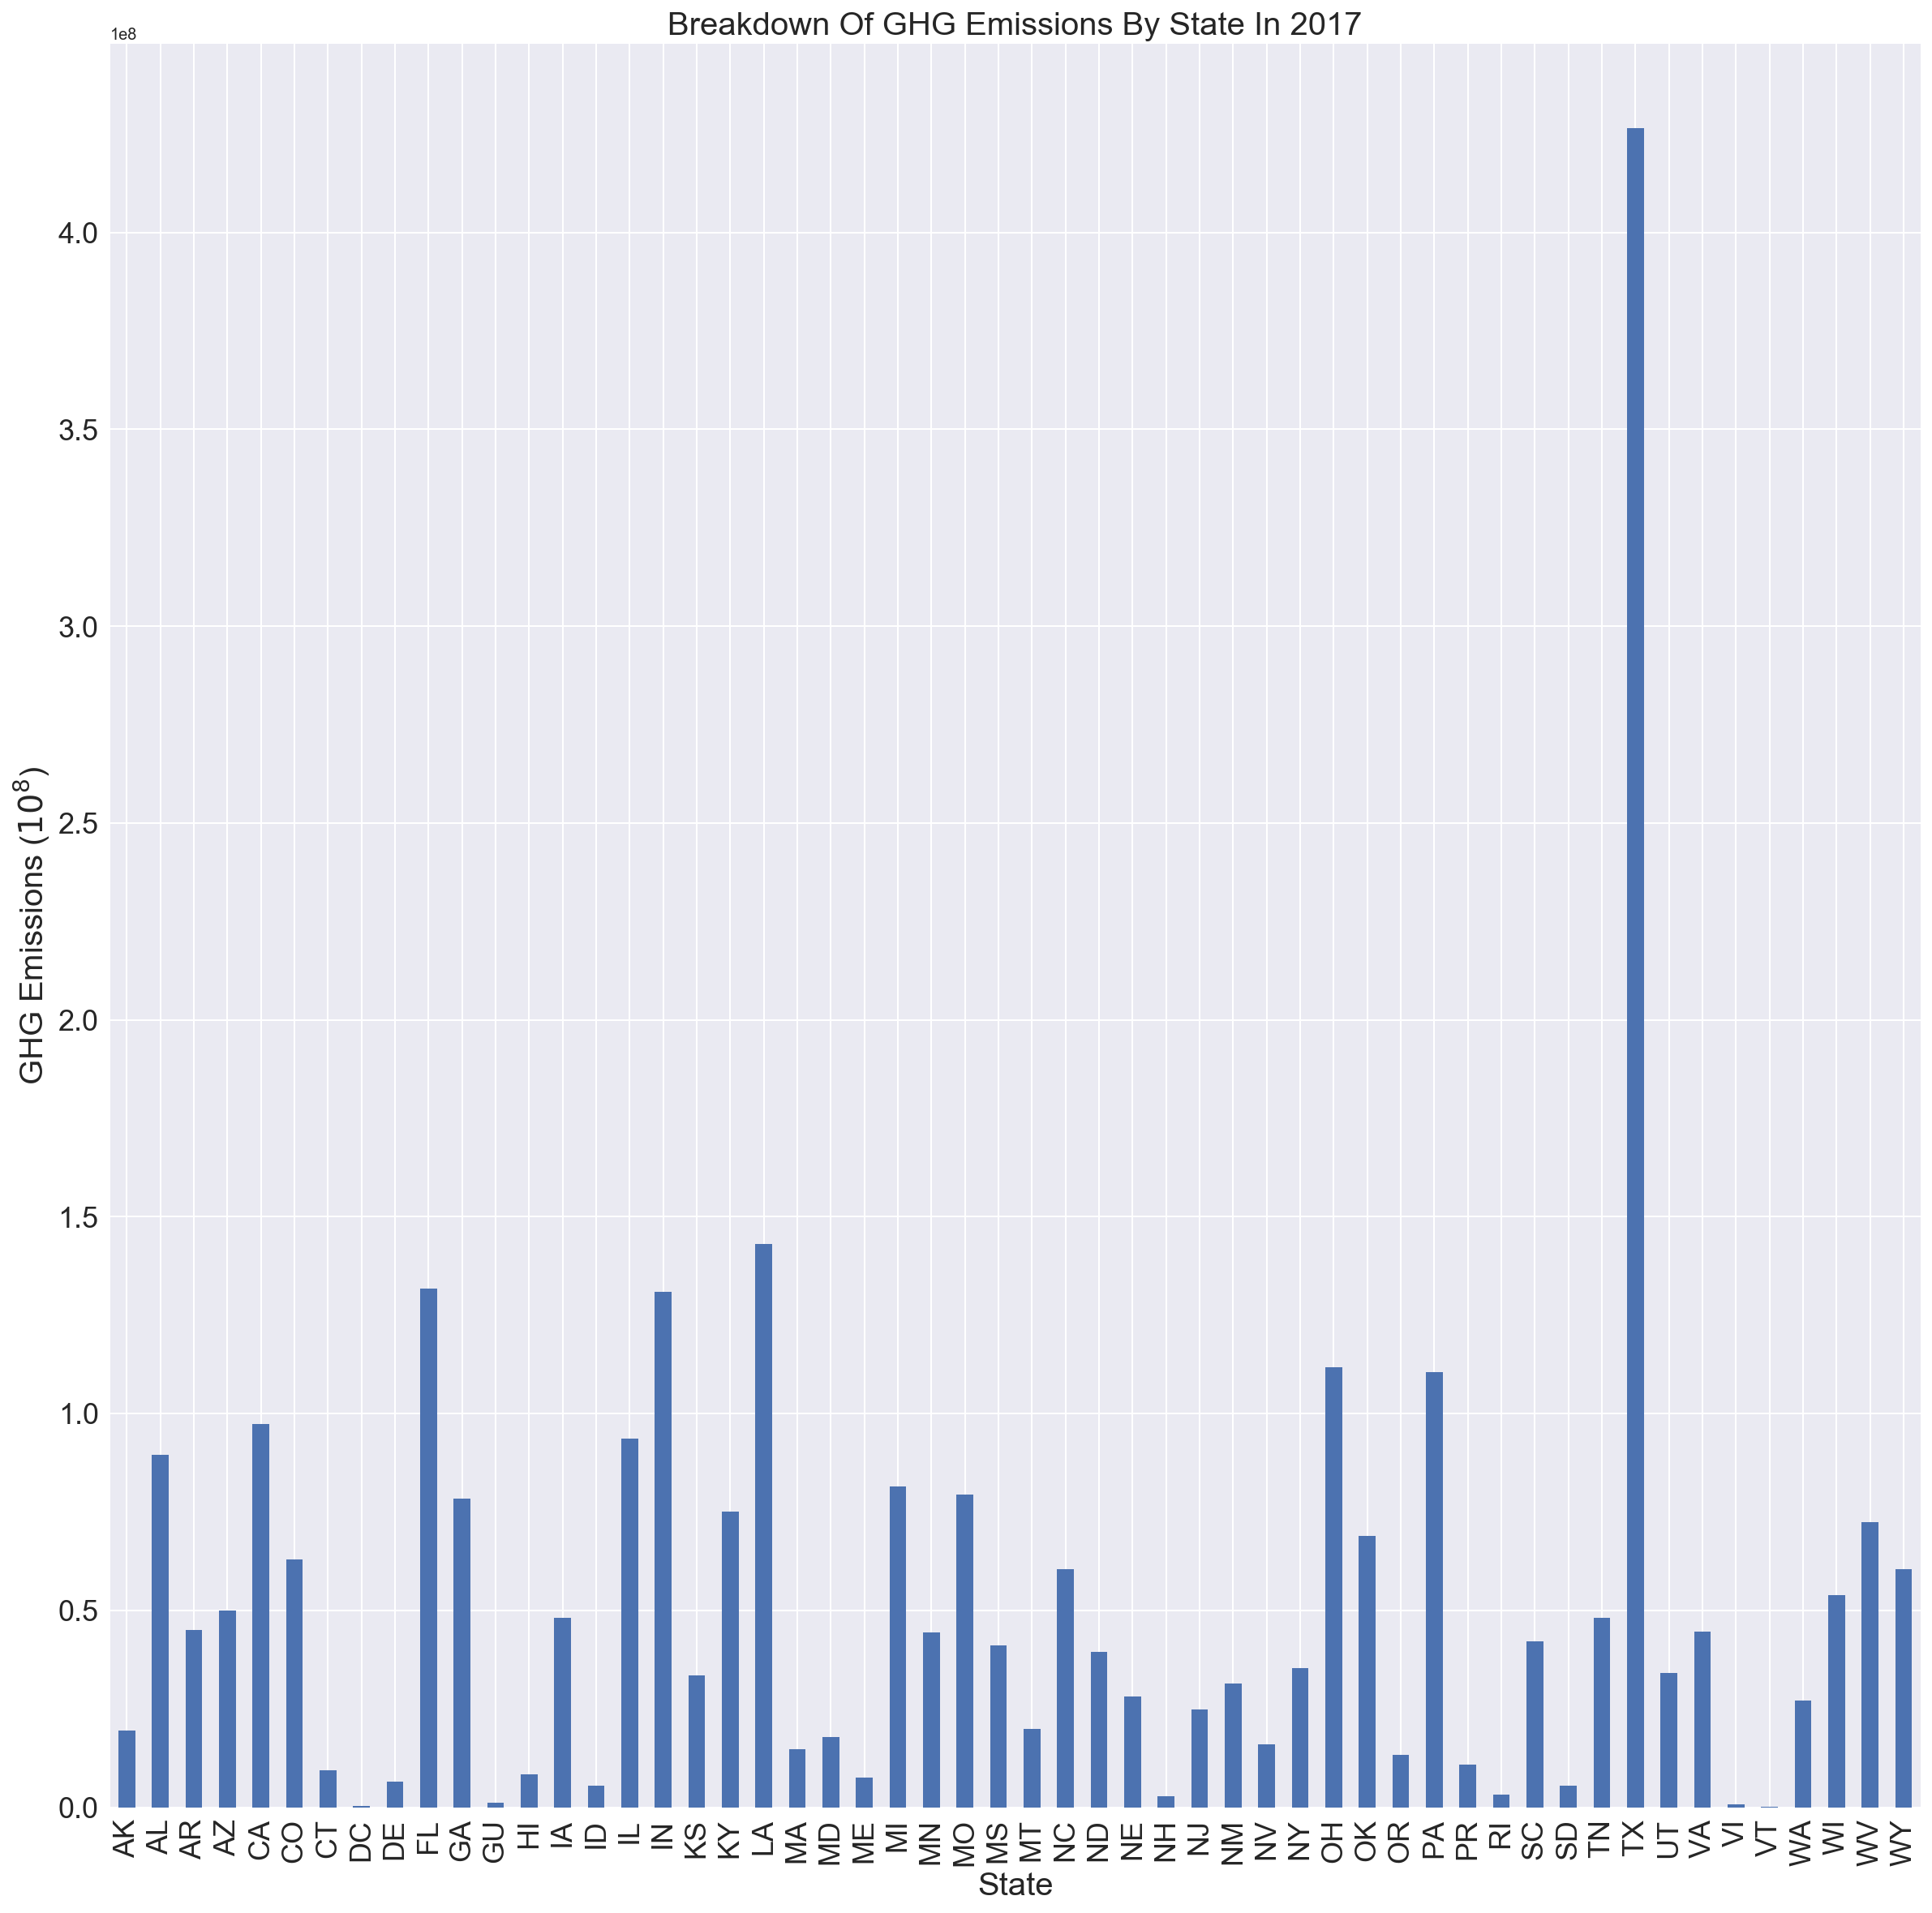

In [13]:
data_2017 = data_formatted[data_formatted['YEAR'] == 2017]

state_data_2017 = data_2017.groupby("STATE").aggregate(np.sum)

state_data_2017_plot = state_data_2017.plot(y="GHG_QUANTITY", kind ='bar', figsize = (20, 20), legend = False, fontsize = 18)
state_data_2017_plot.set_title('Breakdown Of GHG Emissions By State In 2017', fontsize = 20)
state_data_2017_plot.set_xlabel("State", fontsize = 20)
state_data_2017_plot.set_ylabel(r"GHG Emissions ($10^8$)", fontsize = 20)
plt.plot()

However, when we look into GHG emissions per capita in the United States in 2017, we can see that states such as California, Texas, and Indiana appear to be some of the smallest contributors to climate change with states like Wyoming, North Dakota, West Virginia, and Louisiana contributing the most to climate change when considering their population.

/Users/sunnysahu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[]

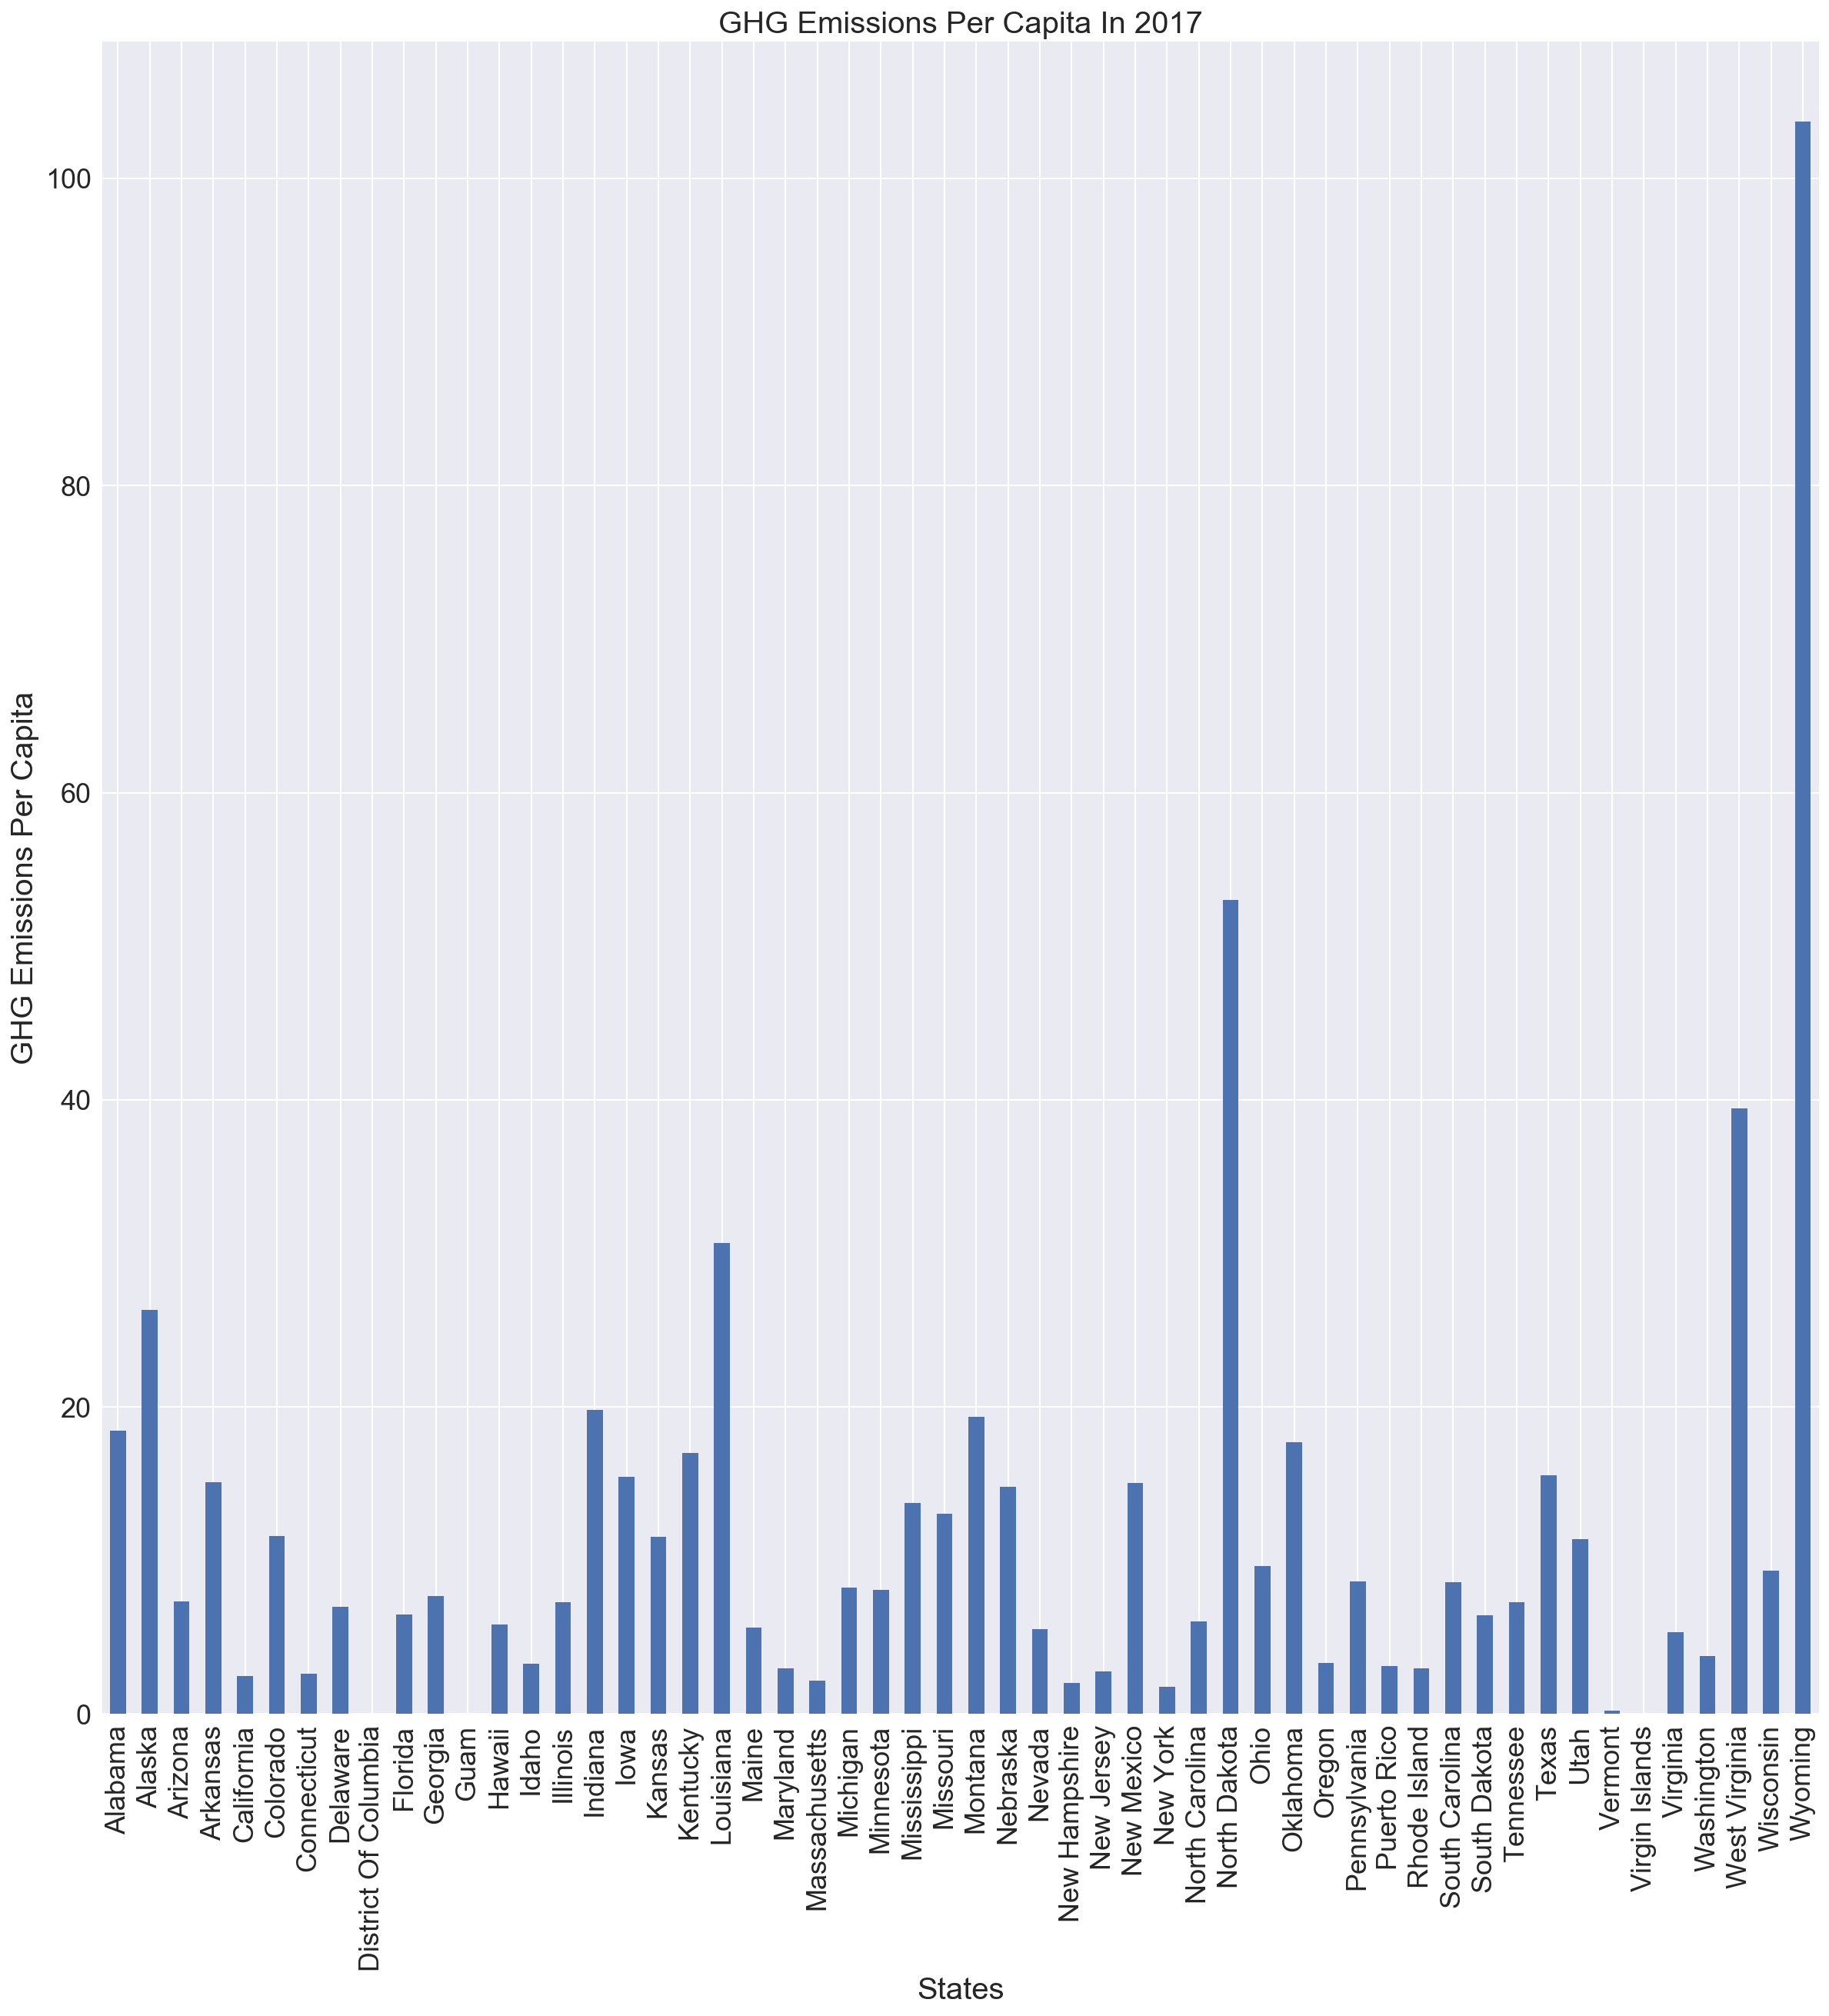

In [14]:
import string
lowerCaseNames = []
for stateNames in data_2017['STATE_NAME']:
    lowerCaseNames.append(string.capwords(stateNames.lower()))
data_2017['STATE_NAME'] = lowerCaseNames
new_state_data_2017 = data_2017.groupby("STATE_NAME").aggregate(np.sum)
joined_table = new_state_data_2017.join(census_data_race_breakdown)
per_capita = [ghg/pop for ghg, pop in zip(joined_table['GHG_QUANTITY'], joined_table['TotalPop'])]
joined_table['PER_CAPITA'] = per_capita
joined_table_plot = joined_table.plot.bar(y="PER_CAPITA", figsize = (20, 20), legend = False, fontsize = 18)
joined_table_plot.set_xlabel("States", fontsize = 20)
joined_table_plot.set_ylabel("GHG Emissions Per Capita", fontsize = 20)
joined_table_plot.set_title("GHG Emissions Per Capita In 2017", fontsize = 20)
plt.plot()

# Spatial Distribution of GHG Emissions

Below, we are going to illustrate the spatial distribution of GHG emissions within the United States. This is just done by taking the 2017 data we had above, turning it into a GeoDataFrame to get points that we can graph onto a US map visualization using Cartopy. As one can see, most of the facilities that promulgate GHG pollutants are located near the Gulf of Mexico and the Northeast. Incidentally, many Hispanic communities are located near this area such as in Texas, Mexico, Puerto Rico, etc.

In [15]:
# define Albers Equal Area projection for contiguous US in cartopy format
proj_aea_contig_us = ccrs.AlbersEqualArea(central_longitude=-96.0,
                                          central_latitude=37.5,
                                          standard_parallels=(29.5, 45.5))

# define Albers Equal Area projection for contiguous US in proj4 format
crs_aea_contig_us = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

In [16]:
# convert pandas dataframe to geopandas geodataframe
data_2017_gpdf = gpd.GeoDataFrame(data_2017, crs=crs_aea_contig_us,
                                     geometry=gpd.points_from_xy(data_2017.LONGITUDE, data_2017.LATITUDE))

IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or Linear

Text(0.5, 1.0, 'Distribution of the Facilities')

IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or Linear

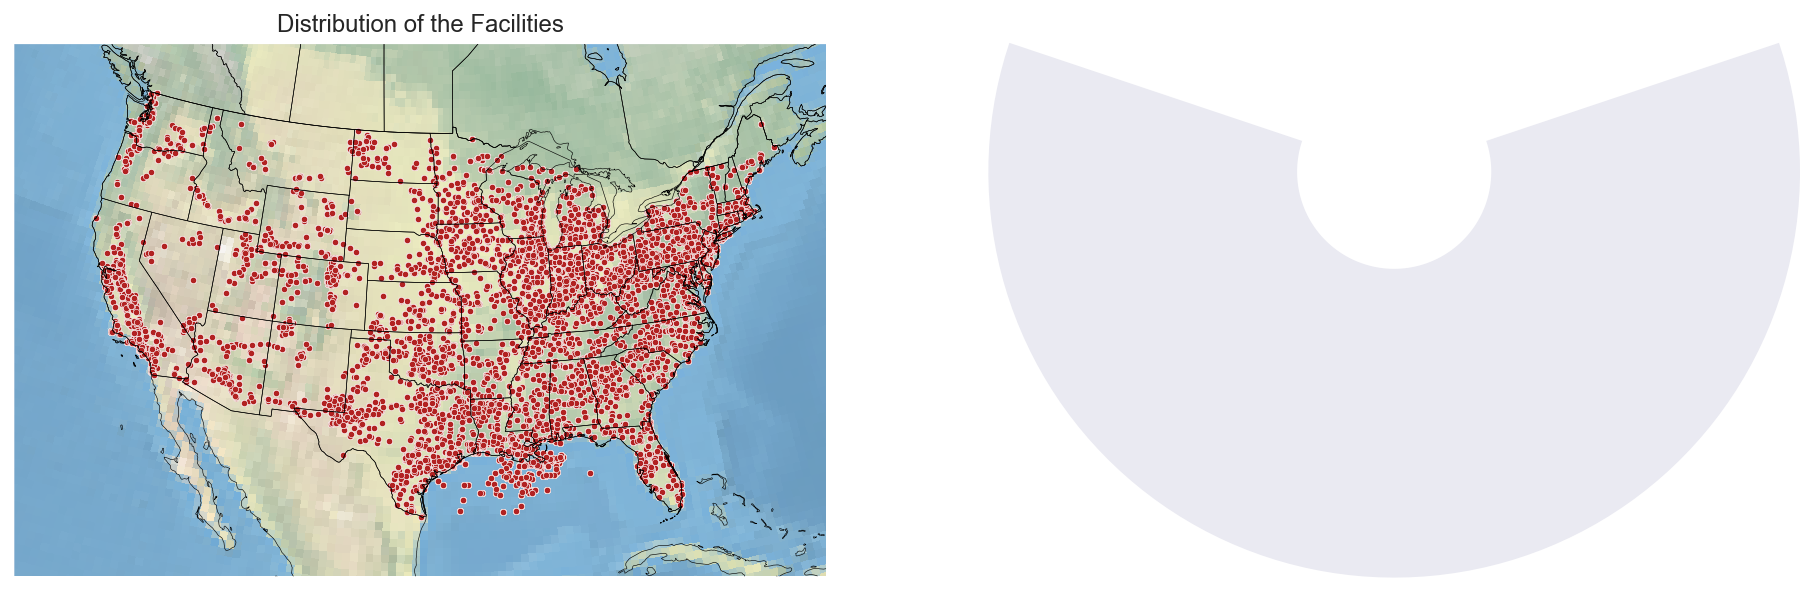

In [17]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2, subplot_kw={'projection': proj_aea_contig_us})

data_2017.plot.scatter("LONGITUDE", "LATITUDE", ax=ax[0], transform=ccrs.PlateCarree(),
                           c="firebrick", s=10, edgecolor="w")
for i in range(1):
    ax[i].set_extent([-123, -72, 20, 52])
    ax[i].stock_img()
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.BORDERS)
    ax[i].add_feature(cartopy.feature.STATES)

ax[0].set_title("Distribution of the Facilities")

Although the United States has been one of the leading nations when discussing GHG emissions, it looks like while we are still emitting close to 3 gigatons of GHG, we are slowly making progress to reducing our GHG emissions through policy, adaptation, and mitigation; however, while one may think this, our forecase predictions as illustrated later in this notebook say otherwise. This is just another way of visualizating the progression of GHG emissions within the 2010 to 2019 period.

Text(0.5, 1.0, 'Progression of GHG Emissions (2010-2019)')

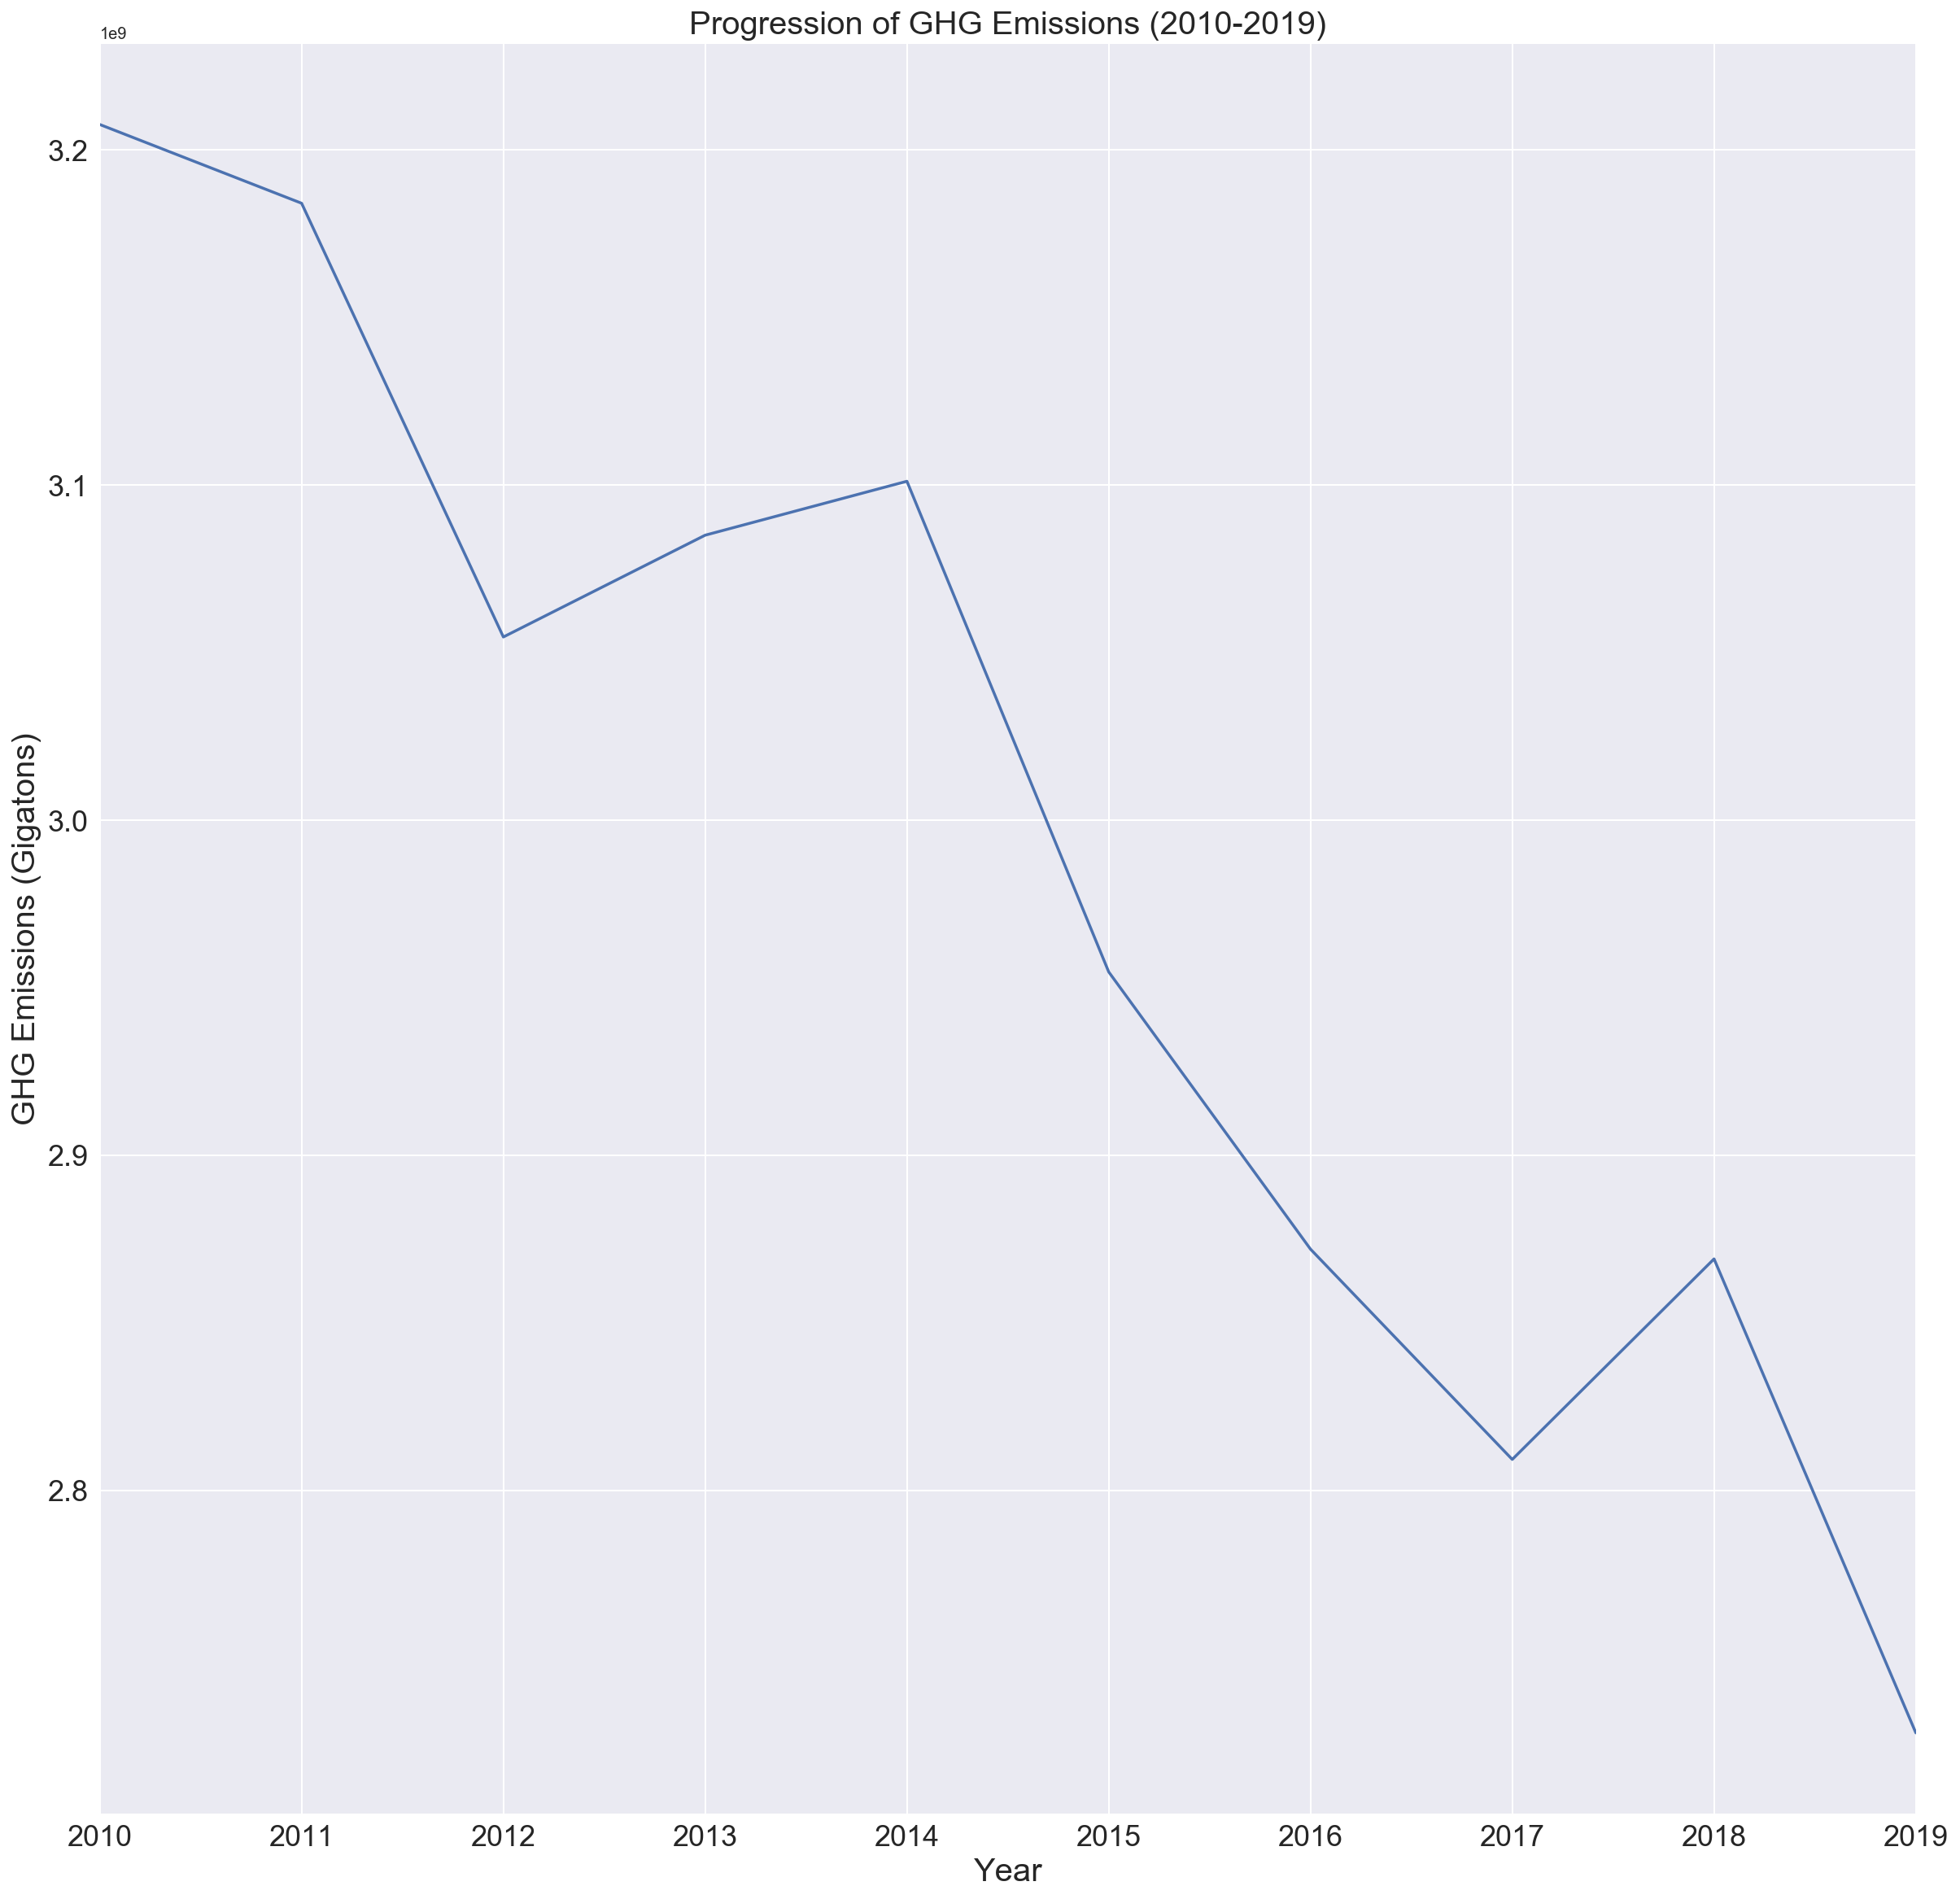

In [52]:
year_breakdown_ghg = year_breakdown[['GHG_QUANTITY']]
years = []
for year in data_formatted['YEAR']:
    if year not in years:
        years.append(year)
year_breakdown_ghg
years = sorted(years)
year_ghg_dict = {'YEAR': years, "GHG_QUANTITY": year_breakdown_ghg['GHG_QUANTITY'].tolist()}
year_breakdown_ghg = pd.DataFrame(data = year_ghg_dict)
year_breakdown_ghg_line = year_breakdown_ghg.plot.line(x = 'YEAR', y='GHG_QUANTITY', legend = False, figsize = (20, 20), fontsize = 18)
year_breakdown_ghg_line.set_xlabel('Year', fontsize = 20)
year_breakdown_ghg_line.set_ylabel('GHG Emissions (Gigatons)', fontsize = 20)
year_breakdown_ghg_line.set_title("Progression of GHG Emissions (2010-2019)", fontsize = 20)

# Forecasting GHG Emissions

It is now time to use forecasting models such as the Autoregressive Integrated Moving Average (ARIMA) time series model to forecast GHG emissions in the future. In order to get a better picture and accuracy with this model, I am using a new dataset which contains U.S data from 1973 to 2016. This gives us more data to work with. The dataset can be found here: [Carbon Emissions Dataset](www.kaggle.com/txtrouble/carbon-emissions/data). Below, we are just loading in the data and doing some manipulation to make sure that our data is formatted properly.

In [37]:
carbon_emissions_df = pd.read_csv("MER_T12_06.csv")
carbon_emissions_df

MSN  YYYYMM    Value  Column_Order  \
0     CLEIEUS  197301   72.076             1   
1     CLEIEUS  197302   64.442             1   
2     CLEIEUS  197303   64.084             1   
3     CLEIEUS  197304   60.842             1   
4     CLEIEUS  197305   61.798             1   
...       ...     ...      ...           ...   
4673  TXEIEUS  201603  115.997             9   
4674  TXEIEUS  201604  113.815             9   
4675  TXEIEUS  201605  129.440             9   
4676  TXEIEUS  201606  172.074             9   
4677  TXEIEUS  201607  201.958             9   

                                           Description  \
0             Coal Electric Power Sector CO2 Emissions   
1             Coal Electric Power Sector CO2 Emissions   
2             Coal Electric Power Sector CO2 Emissions   
3             Coal Electric Power Sector CO2 Emissions   
4             Coal Electric Power Sector CO2 Emissions   
...                                                ...   
4673  Total Energy Electric Power Sector CO2 Emissions   
4674  Total Energy Electric Power Sector CO2 Emissions   
4675  Total Energy Electric Power Sector CO2 Emissions   
4676  Total Energy Electric Power Sector CO2 Emissions   
4677  Total Energy Electric Power Sector CO2 Emissions   

                                       Unit  
0     Million Metric Tons of Carbon Dioxide  
1     Million Metric Tons of Carbon Dioxide  
2     Million Metric Tons of Carbon Dioxide  
3     Million Metric Tons of Carbon Dioxide  
4     Million Metric Tons of Carbon Dioxide  
...                                     ...  
4673  Million Metric Tons of Carbon Dioxide  
4674  Million Metric Tons of Carbon Dioxide  
4675  Million Metric Tons of Carbon Dioxide  
4676  Million Metric Tons of Carbon Dioxide  
4677  Million Metric Tons of Carbon Dioxide  

[4678 rows x 6 columns]

In [40]:
carbon_emissions_df_yy = []
for items in carbon_emissions_df['YYYYMM']:
    carbon_emissions_df_yy.append(int(str(items)[:4]))
carbon_emissions_df_formatted = carbon_emissions_df[['YYYYMM', 'Value']]
carbon_emissions_df_formatted['YYYYMM'] = carbon_emissions_df_yy
carbon_emissions_df_formatted.rename(columns={'YYYYMM': 'Year'}, inplace = True)
values_float = []
for values in carbon_emissions_df_formatted['Value']:
    values_float.append(float(values))
carbon_emissions_df_formatted['Value'] = values_float
carbon_emissions_df_formatted

/Users/sunnysahu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sunnysahu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Year    Value
0     1973   72.076
1     1973   64.442
2     1973   64.084
3     1973   60.842
4     1973   61.798
...    ...      ...
4673  2016  115.997
4674  2016  113.815
4675  2016  129.440
4676  2016  172.074
4677  2016  201.958

[4678 rows x 2 columns]

In [43]:
carbon_emissions_by_year_df = carbon_emissions_df_formatted.groupby('Year').aggregate(np.sum)
carbon_emissions_by_year_df
new_data_years = []
for year in carbon_emissions_df_formatted['Year']:
    if year not in new_data_years:
        new_data_years.append(year)
new_data_years = sorted(new_data_years)
new_data_ghg_dict = {'Year': new_data_years, "Value": carbon_emissions_by_year_df['Value'].tolist()}
new_year_breakdown_df = pd.DataFrame(data = new_data_ghg_dict)
new_year_breakdown_df

Year     Value
0   1973  5696.814
1   1974  5530.164
2   1975  5471.627
3   1976  5949.979
4   1977  6380.023
5   1978  6416.280
6   1979  6536.731
7   1980  6588.183
8   1981  6550.347
9   1982  6169.424
10  1983  6325.479
11  1984  6555.302
12  1985  6648.124
13  1986  6681.416
14  1987  6918.400
15  1988  7275.828
16  1989  7569.725
17  1990  7527.635
18  1991  7507.588
19  1992  7531.141
20  1993  7856.183
21  1994  7944.188
22  1995  7961.614
23  1996  8264.266
24  1997  8555.101
25  1998  8977.184
26  1999  9012.177
27  2000  9423.671
28  2001  9294.677
29  2002  9310.431
30  2003  9473.008
31  2004  9599.374
32  2005  9864.337
33  2006  9542.384
34  2007  9808.444
35  2008  9569.857
36  2009  8697.084
37  2010  9144.994
38  2011  8731.033
39  2012  8174.518
40  2013  8244.760
41  2014  8250.599
42  2015  7722.439
43  2016  2063.708

Below, we are using the Autoregressive Integrated Moving Average (ARIMA) time series model to forecast GHG emissions in the future. We see that while we will continue to decrease our GHG emissions for a short period, they will continue to grow substantially. While 9 Gigatons is an overestimate of GHG emissions, it is on par with other estimations if we continue to consume as we have been 

Text(0.5, 1.0, 'GHG Emissions Time Series Forecast Till 2050')

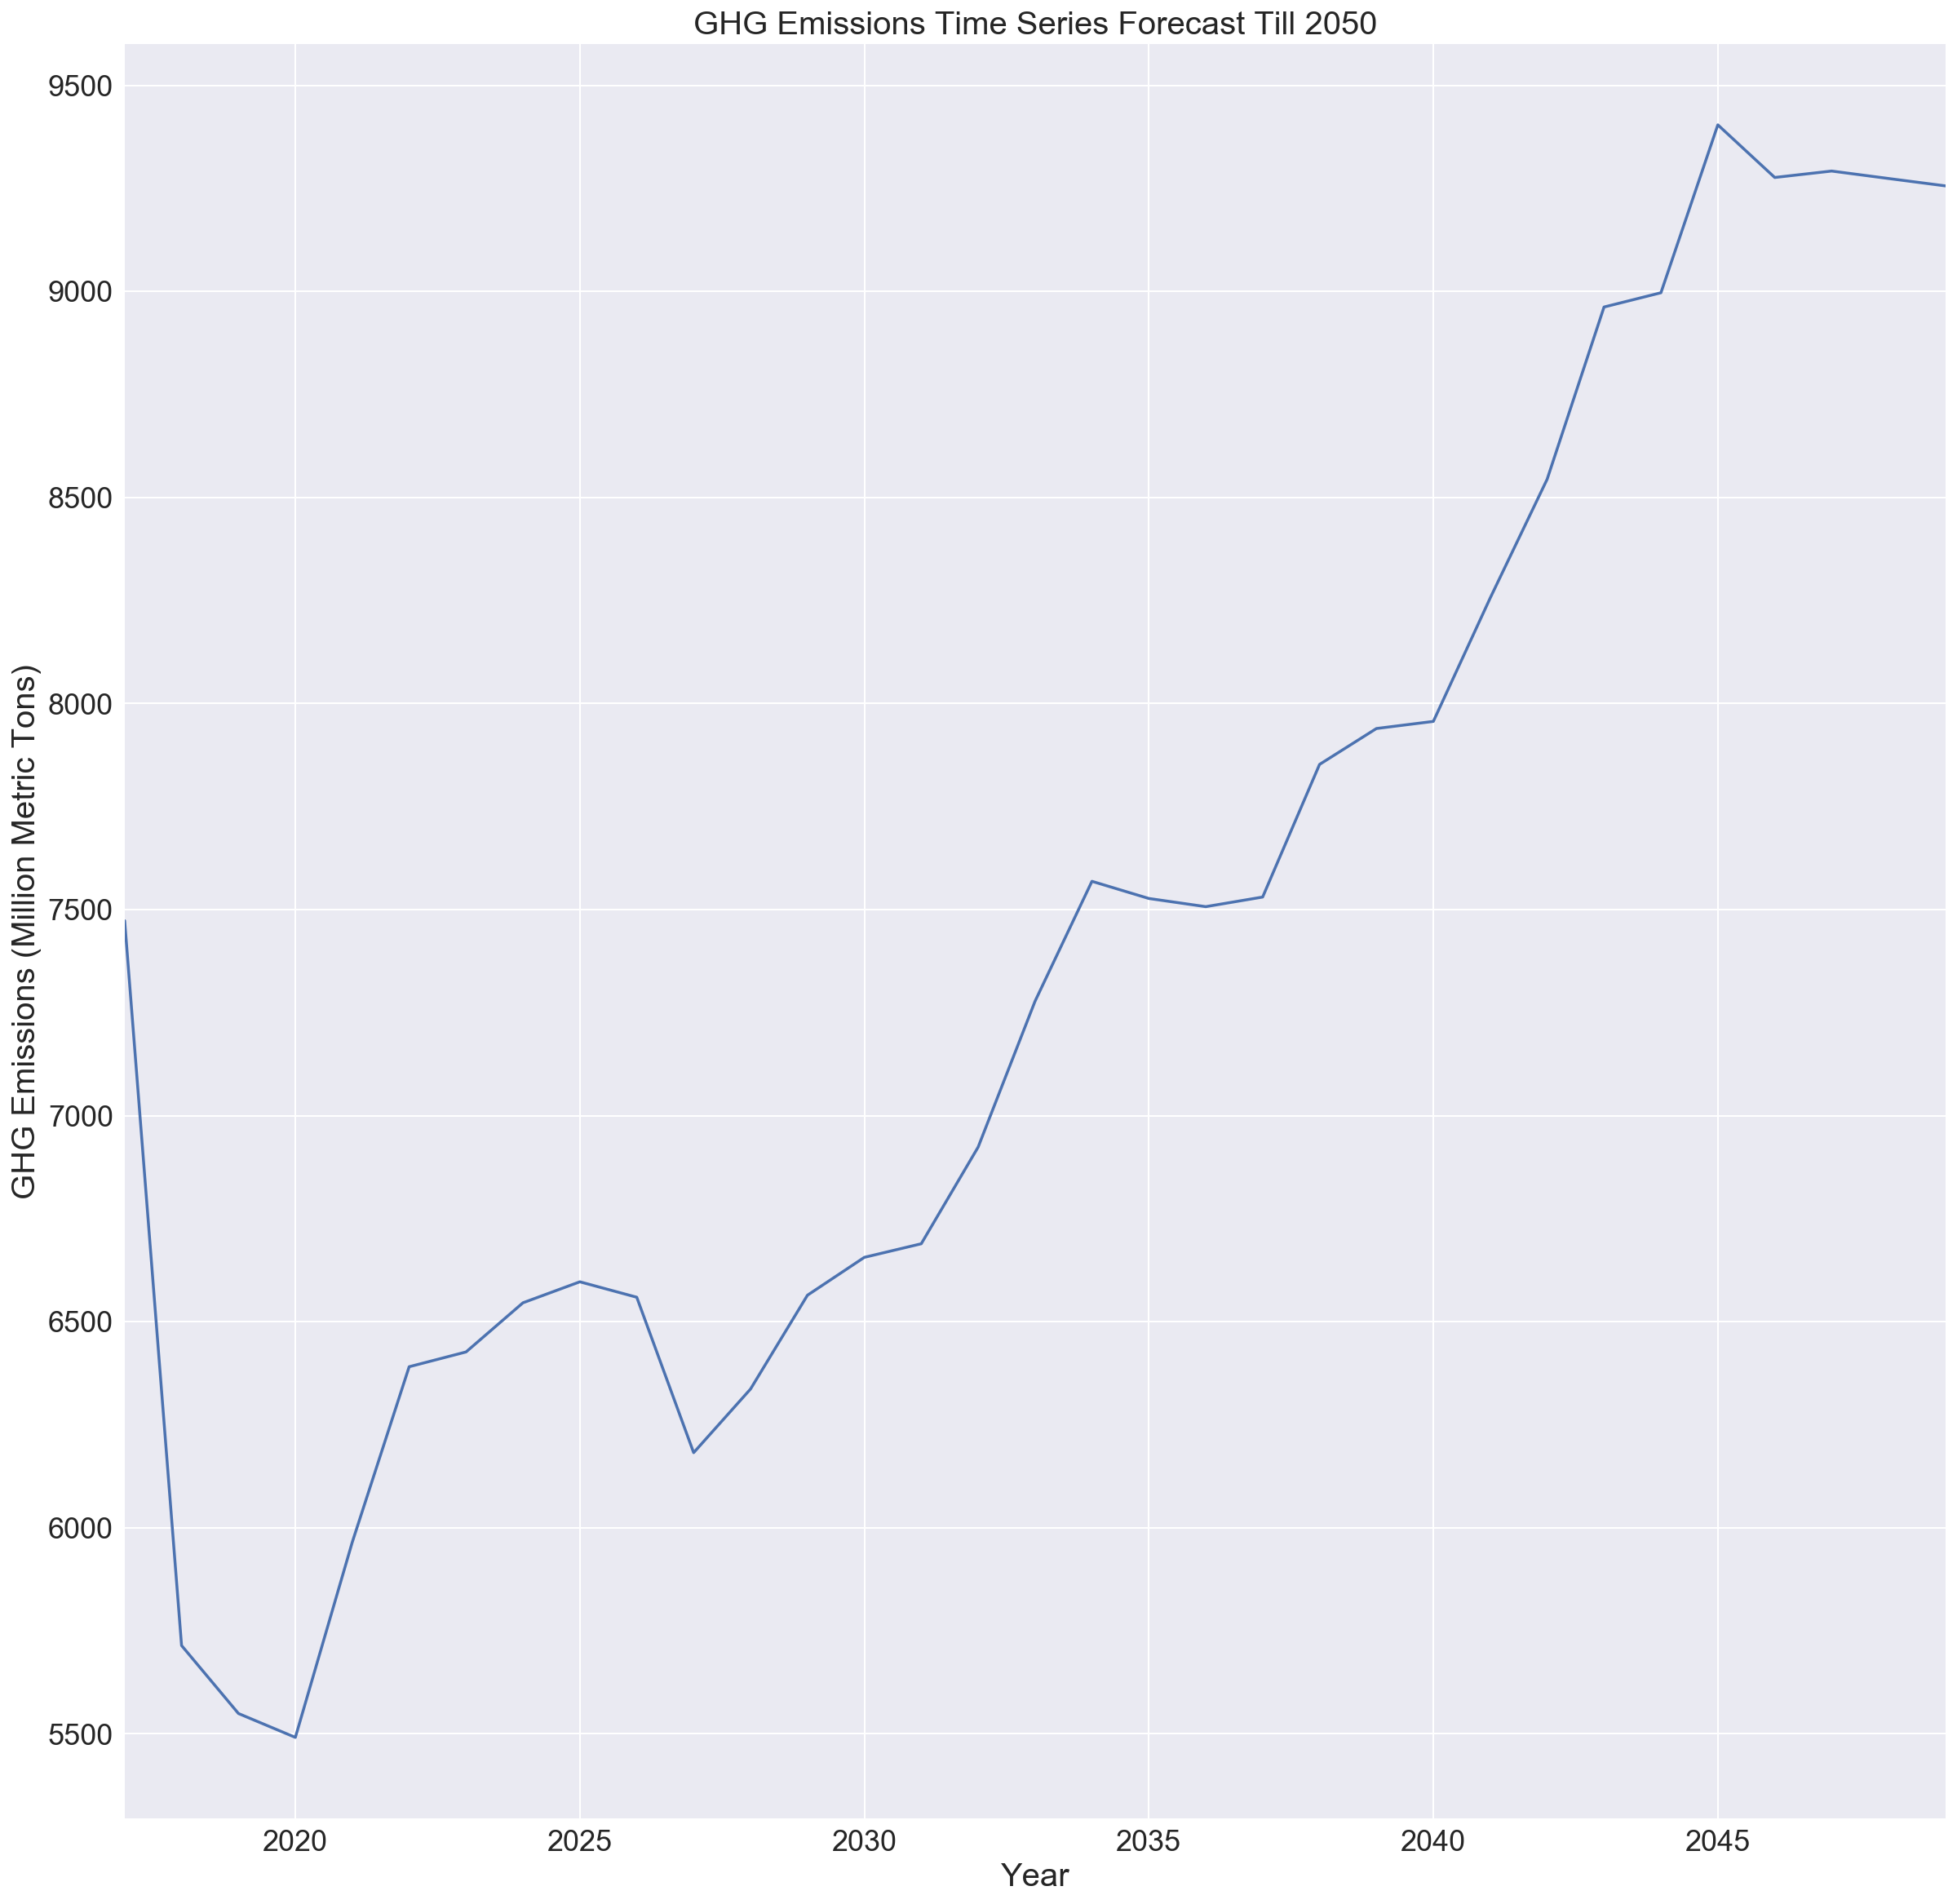

In [58]:
from statsmodels.tsa.arima_model import ARIMA
train = new_year_breakdown_df.iloc[0:30]
test = new_year_breakdown_df.iloc[30:]
model = ARIMA(train['Value'], order=(1,0,0))
model = model.fit()
model.summary()
future_year_index = pd.date_range(start='2017', end='2050', freq = 'Y')
pred = model.predict(start = 0, end = 32)
pred.index = future_year_index
pred_line_plot = pred.plot(figsize=(20, 20), fontsize = 18)
pred_line_plot.set_xlabel('Year', fontsize = 20)
pred_line_plot.set_ylabel('GHG Emissions (Million Metric Tons)', fontsize = 20)
pred_line_plot.set_title('GHG Emissions Time Series Forecast Till 2050', fontsize = 20)

Here, we are compiling data from Texas to prepare to make forecasting predications about GHG emissions within Texas.

In [70]:
texas_data = data_formatted[data_formatted['STATE'] == 'TX']
texas_data_grouped['GHG_QUANTITY'] = texas_data.groupby('YEAR').aggregate(np.sum)['GHG_QUANTITY']
texas_data_year_dict = {'YEAR': [year for year in range(2010, 2020)], 'GHG_QUANTITY': texas_data_grouped['GHG_QUANTITY'].tolist()}
texas_data_by_year = pd.DataFrame(data=texas_data_year_dict)
texas_data_by_year

YEAR  GHG_QUANTITY
0  2010  3.783284e+08
1  2011  4.119437e+08
2  2012  4.019779e+08
3  2013  4.190124e+08
4  2014  4.230496e+08
5  2015  4.121373e+08
6  2016  4.213061e+08
7  2017  4.265620e+08
8  2018  4.363889e+08
9  2019  4.358324e+08

Below, we are using the Autoregressive Integrated Moving Average (ARIMA) time series model to forecast GHG emissions in the future. We see that Texas GHG emissions will increase but will plateau. Although the GHG emissions are forecasted to plateau, this is still concerning for Hispanics 

Text(0.5, 1.0, 'GHG Emissions Time Series Forecast Till 2050 In Texas')

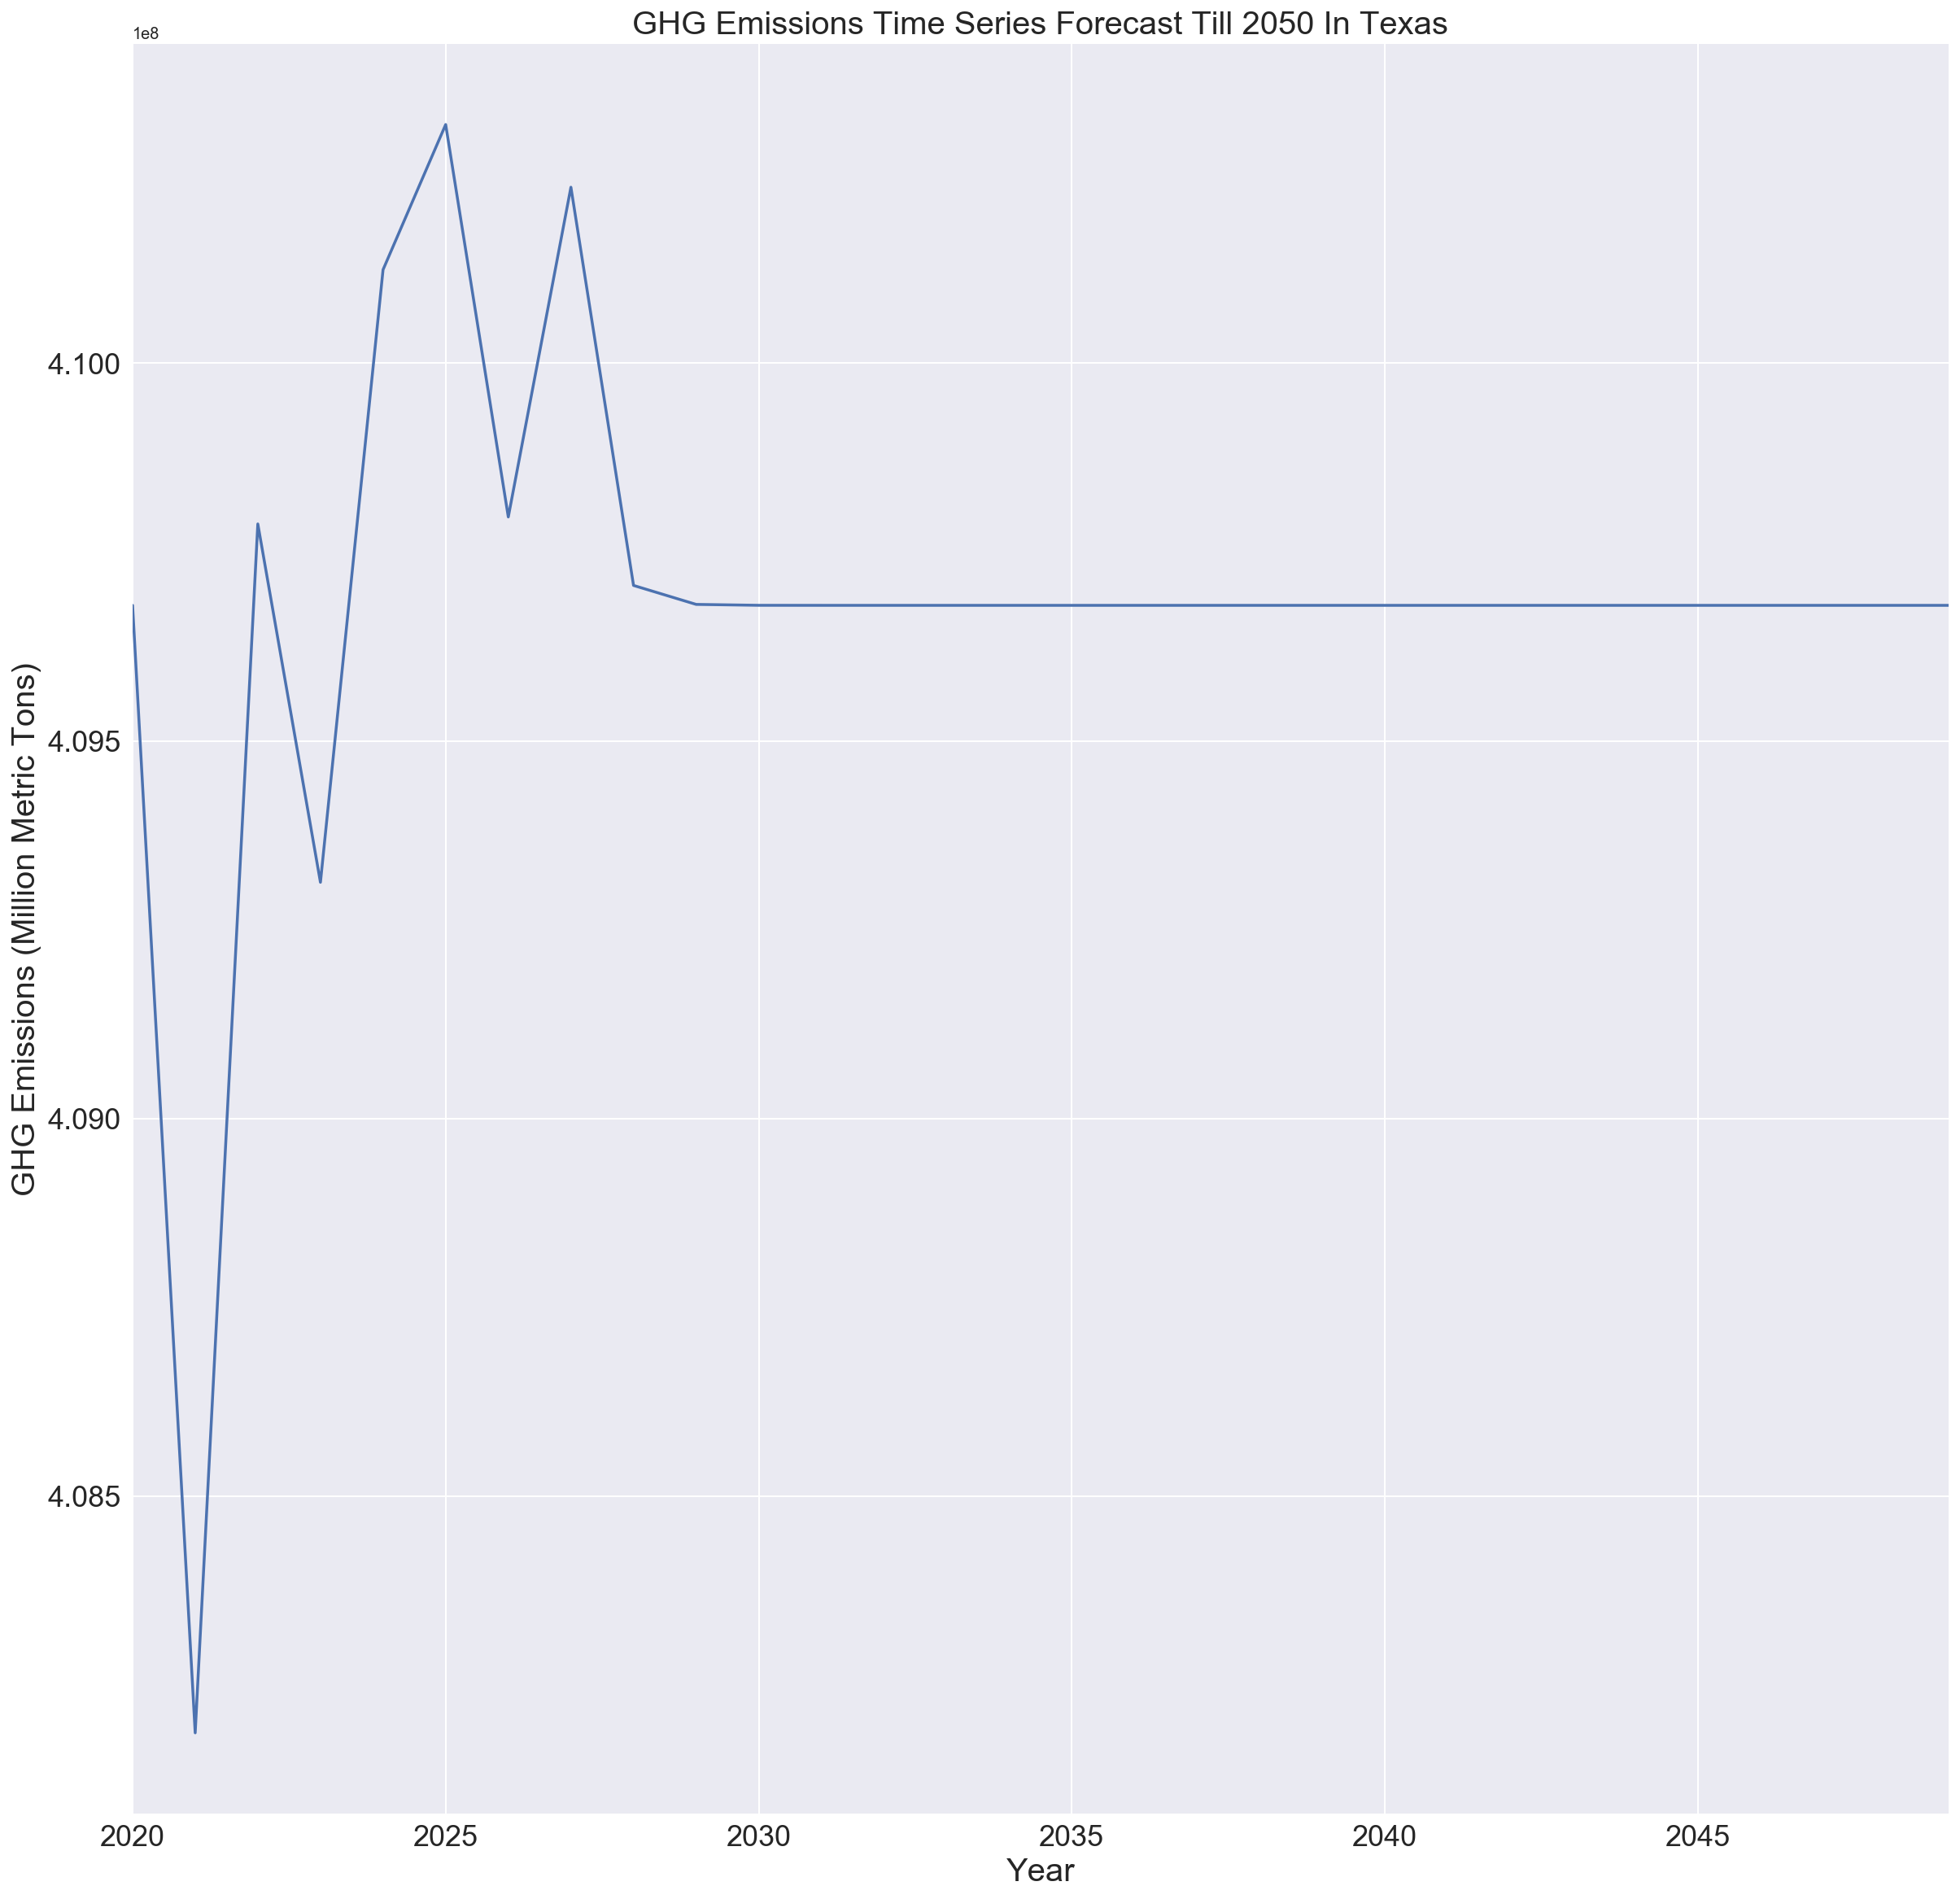

In [73]:
train = texas_data_by_year.iloc[0:7]
test = new_year_breakdown_df.iloc[7:]
model = ARIMA(train['GHG_QUANTITY'], order=(1,0,0))
model = model.fit()
model.summary()
future_year_index = pd.date_range(start='2020', end='2050', freq = 'Y')
pred = model.predict(start = 0, end = 29)
pred.index = future_year_index
pred_line_plot = pred.plot(figsize=(20, 20), fontsize = 18)
pred_line_plot.set_xlabel('Year', fontsize = 20)
pred_line_plot.set_ylabel('GHG Emissions (Million Metric Tons)', fontsize = 20)
pred_line_plot.set_title('GHG Emissions Time Series Forecast Till 2050 In Texas', fontsize = 20)

# Conclusion

Through data analysis, we were able to conclude that while GHG emissions have been declining these past 10 years, maintaining our current consumption patterns and policies will inevitably cause GHG emissions to grow substantially.
We were able to visualize the spatial distribution of GHG emissions and determine that most of the facilities that promulgate GHG pollutants are located near the Gulf of Mexico and the Northeast. Incidentally, many Hispanic communities are located near this area such as in Texas, Mexico, Puerto Rico, etc. This helped us begin to analyze how climate change has affected Hispanic communities. We found that according to the Environmental Defense Fund (EDF), “Climate change has a tremendous impact on the health, livelihoods, and overall well-being of U.S. Latinos ... More than half (55%) of Latino-Americans live in three states that are already experiencing serious effects related to climate change”. Some further research allowed us to notice  that Puerto Rico's climate change problems are largely synonymous to New Orleans and that higher Hispanic poverty levels and lower rates of health insurance mean that Hispanic communities are more prone to climate change effects. Through the United States Census Bureau's forecasting model along with our own, we saw that the Hispanic population within the United States is expected to grow to up to 100 million along the prediction that Texas GHG emissions will increase and plateau, but this is still concerning for Hispanics. In summation, policy, community outreach, adaptation, and mitigation strategies should continue to be adopted to help protect marginalized populations such as African Americans and Hispanics from the adverse effects of climate change